# Artificial Neural Networks and Deep Learning

Team Name: **SoFarSoGood**  
Members:  
- **Davide Corradina** (252117)  
- **Federico de Introna** (251274)  
- **Francesco Di Giore** (252126)


In [3]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import cv2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


seed = 42
np.random.seed(42)
tf.random.set_seed(42)
AUTOTUNE = tf.data.AUTOTUNE

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


In [2]:
#Useful parameters

BATCH_SIZE = 32

LEARNING_RATE = 1e-3

PATIENCE = 20

EPOCHS = 1000

SPLITS_SIZE = 0.2

NUM_CLASSES = 5

## Loading and preparing the dataset

In [3]:
data = np.load("/kaggle/input/an2dl-mars/mars_filtered_dataset (1).npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [4]:
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [5]:
# Add color channel (datasets already rescaled between 0 and 1)
X_train = X_train[..., np.newaxis]
# X_test = X_test[..., np.newaxis] color channel already inserted in the loaded test dataset

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [6]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE,random_state=seed)

print("Data splitted!")

print(X_val.shape)
print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Splitting data...
Data splitted!
(501, 64, 128)

Number of images:
Train: 2004
Validation: 501
Test: 10022


In [7]:
import albumentations as A

# Define the Albumentations augmentation pipeline
augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],p=0.9),
        A.OneOf([
                A.VerticalFlip(p=1),
                A.Rotate(limit=(180, 180), p=1),
            ],p=0.9),
        A.OneOf([
                A.ElasticTransform(p=1),
                A.GridDistortion(p=1),
                A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)
            ], p=0.9)
])

In [8]:
# Function to apply Albumentations transformations
def aug_fn(image, label):
    # Convert TensorFlow tensors to NumPy
    image = image.numpy()
    label = label.numpy()

    # Apply the Albumentations transformation
    augmented = augmentation(image=image, mask=label)
    aug_image = augmented["image"]
    aug_label = augmented["mask"]

    return aug_image, aug_label

# Wrapper to apply augmentation within TensorFlow pipelines
def tf_augment(image, label):
    # Use tf.py_function to apply aug_fn
    aug_image, aug_label = tf.py_function(
        func=aug_fn, inp=[image, label], Tout=[tf.float32, tf.float32]
    )

    # Set shapes explicitly because tf.py_function loses shape information
    aug_image.set_shape(image.shape)
    aug_label.set_shape(label.shape)
    aug_label = tf.cast(aug_label, tf.int32)

    return aug_image, aug_label

In [9]:
def to_cast(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    return image,label


def one_hot_encode_mask(mask, num_classes=5):
    # Ensure the mask is an integer type
    mask = tf.cast(mask, tf.int32)
    
    # Apply one-hot encoding
    one_hot_mask = tf.one_hot(mask, depth=num_classes)
    
    return one_hot_mask

In [10]:
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4,  # big rock
}

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    If the input is one-hot encoded, it will be converted to single-channel first.
    """
    # If label is one-hot encoded, convert it to single-channel
    if label.ndim == 3:  # Shape: (H, W, num_classes)
        label = np.argmax(label, axis=-1)  # Convert to single-channel

    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    Handles both integer and one-hot encoded labels.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        
        # Check if labels are one-hot encoded
        if labels_np.ndim == 4:  # Shape: (batch_size, H, W, num_classes)
            labels_np = np.argmax(labels_np, axis=-1)  # Convert to single-channel

        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')


    plt.tight_layout()
    plt.show()
    plt.close()

In [13]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, concat=0, seed=None):
   
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        to_cast,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    print(len(dataset))

    if augment:
        temp_1 = dataset
        temp_2 = dataset
        temp_1 = temp_1.map(tf_augment, num_parallel_calls=tf.data.AUTOTUNE)
        temp_2 = temp_2.map(tf_augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.concatenate(temp_1.shuffle(buffer_size=batch_size * 2, seed=seed)).concatenate(temp_2.shuffle(buffer_size=batch_size * 2, seed=seed))

    print(len(dataset))


    dataset = dataset.map(lambda image, mask: (image, one_hot_encode_mask(mask, 5)))
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [14]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    concat = 3,
    seed=seed
)

val_dataset = make_dataset(
    X_val, Y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in val_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break



Creating datasets...
2004
6012
501
501
Datasets created!

Input shape: (64, 128)
Images shape: (32, 64, 128)
Labels shape: (32, 64, 128, 5)
Labels dtype: <dtype: 'float32'>


## The Model

In [15]:
from keras.layers import *
from keras.models import Model
from keras.initializers import get as get_init, serialize as serial_init
import tensorflow.keras.backend as K
import tensorflow as tf
@tf.keras.utils.register_keras_serializable()
def ConvBnAct(x,filters,kernel_size, activation='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

@tf.keras.utils.register_keras_serializable()
class MatMulLayer(Layer):
    def call(self, x,y, t_a = False, t_b = False):
        if t_a :
            return tf.linalg.matmul(x,y,transpose_a=True)
        elif t_b:
            return tf.linalg.matmul(x,y,transpose_b=True)
        return tf.linalg.matmul(x,y)


@tf.keras.utils.register_keras_serializable()
def ObjectAttentionBlock2D(feats,ctx,filters, scale = 1.0):
    ctx = tf.keras.layers.Permute((2, 1))(ctx)
    BS, H, W, C = feats.shape
    f_pixel_1 = ConvBnAct(feats,filters, (1, 1))
    query = ConvBnAct(f_pixel_1,filters, (1, 1))
    query = tf.keras.layers.Reshape((-1, C))(query)
    key = tf.keras.layers.Reshape((-1, C))(ctx)                 # (BS, C2, C)
    value = tf.keras.layers.Reshape((-1, C))(ctx)  
    sim_map = MatMulLayer()(query, key, t_b=True)    # (BS, N, C2)
    sim_map = (filters ** -0.5) * sim_map                  # (BS, N, C2)
    sim_map = tf.keras.layers.Activation("softmax")(sim_map)     
    context = MatMulLayer()(sim_map, value)                   # (BS, N, C)
    context = tf.keras.layers.Reshape((H, W, C))(context) 
    context = ConvBnAct(context,filters,(1,1))
    return context
    
@tf.keras.utils.register_keras_serializable()
def SpatialGather_Module(features,probabilities):
        BS, H, W, C = probabilities.shape
        p = tf.keras.layers.Reshape((-1, C))(probabilities)             # (BS, N, C)
        f = tf.keras.layers.Reshape((-1, features.shape[-1]))(features) # (BS, N, C2)
        p = tf.keras.layers.Activation("softmax")(p)                                # (BS, N, C)
        ocr_context = MatMulLayer()(p, f, t_a=True)  
        return ocr_context
    
@tf.keras.utils.register_keras_serializable()
def AtrousSeparableConvolutioBnRelu(x,filters,kernel_size,dilation):
        x = tf.keras.layers.SeparableConv2D(
        filters=filters,
        kernel_size = kernel_size,
        padding="same",
        dilation_rate=dilation,
        depthwise_initializer="glorot_normal",
        pointwise_initializer="glorot_normal",
        depthwise_regularizer=tf.keras.regularizers.l2(1e-4),
        pointwise_regularizer=tf.keras.regularizers.l2(1e-4)
        )(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

@tf.keras.utils.register_keras_serializable()
def SpatialOCR_ASP_Module(x,probabilities, filters, dilations = (12,24,36), dropout = 0.1):
    feat1 = ConvBnAct(x,filters, (3,3))
    context = SpatialGather_Module(feat1,probabilities)
    feat1 = ObjectAttentionBlock2D(feat1,context, filters)
    feat2 = ConvBnAct(x,filters, (1,1))
    feat3 = AtrousSeparableConvolutioBnRelu(x, filters, 3, dilations[0])
    feat4 = AtrousSeparableConvolutioBnRelu(x, filters, 3, dilations[1])
    feat5 = AtrousSeparableConvolutioBnRelu(x, filters, 3, dilations[2])
    output = tf.keras.layers.Concatenate(axis=3)([feat1, feat2, feat3, feat4, feat5])
    ouptut = ConvBnAct(output,filters, (1,1))
    output =  tf.keras.layers.Dropout(dropout)(output)
    return output
    

In [16]:
@tf.keras.utils.register_keras_serializable()
def cbam_block(cbam_feature, ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature) 

	return cbam_feature

@tf.keras.utils.register_keras_serializable()
def channel_attention(input_feature, ratio=8):
	
	channel_axis = -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	avg_pool = shared_layer_one(avg_pool)
	avg_pool = shared_layer_two(avg_pool)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	max_pool = shared_layer_one(max_pool)
	max_pool = shared_layer_two(max_pool)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	return multiply([input_feature, cbam_feature])
    
@tf.keras.utils.register_keras_serializable()
def spatial_attention(input_feature):
    kernel_size = 7
    channel = input_feature.shape[-1]
    cbam_feature = input_feature
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True), output_shape=(input_feature.shape[1], input_feature.shape[2], 1))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True), output_shape=(input_feature.shape[1], input_feature.shape[2], 1))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
    return Multiply([input_feature, cbam_feature])

In [4]:
from keras.layers import *
from keras.models import Model

@tf.keras.utils.register_keras_serializable()
def ASPP(inputs, filters):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y_pool = Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization()(y_pool)
    y_pool = Activation('relu')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

@tf.keras.utils.register_keras_serializable()
def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

@tf.keras.utils.register_keras_serializable()
def attention_gate(g, s, num_filters):
    # Wg = MaxPool2D(pool_size=(2, 2))(g)
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s
@tf.keras.utils.register_keras_serializable()
def attention_gate_out(g, s, num_filters):
    # Wg = MaxPool2D(pool_size=(2, 2))(g)
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

@tf.keras.utils.register_keras_serializable()
def resnet_block(inputs, num_filters, strides=1):
    ## SE
    se = squeeze_excite_block(inputs)
    # se = cbam_block(inputs)
    

    ## Conv 1
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    ## Shortcut
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(se)

    ## Add
    x = Add()([x, s])

    return x

@tf.keras.utils.register_keras_serializable()
def conv_block(inputs, num_filters, strides=1):
    ## Conv 1
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    ## Shortcut
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    ## Add
    x = Add()([x, s])

    return x
    
@tf.keras.utils.register_keras_serializable()
def fusion_block(u1,u2, u3, u4):
    out_1 = UpSampling2D(size=(8, 8), interpolation='bilinear')(u1)
    out_2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(u2)
    out_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')(u3)
    out_4 = UpSampling2D(size=(1, 1), interpolation='bilinear')(u4)

    out = output_union(out_1, out_2, out_3, out_4)
    return out
@tf.keras.utils.register_keras_serializable()
def weighted_fusion(skip, upsampled):
    skip_weight = Conv2D(1, (1, 1), activation='sigmoid')(skip)
    upsampled_weight = Conv2D(1, (1, 1), activation='sigmoid')(upsampled)
    weighted_skip = Multiply()([skip, skip_weight])
    weighted_upsampled = Multiply()([upsampled, upsampled_weight])
    return Add()([weighted_skip, weighted_upsampled])
@tf.keras.utils.register_keras_serializable()
def output_union(u1, u2, u3, u4):
    out_1 = Conv2D(1, (1, 1), activation='sigmoid')(u1)
    out_2 = Conv2D(1, (1, 1), activation='sigmoid')(u2)
    out_3 = Conv2D(1, (1, 1), activation='sigmoid')(u3)
    out_4 = Conv2D(1, (1, 1), activation='sigmoid')(u4)
    out_1 = Multiply()([u1, out_1])
    out_2 = Multiply()([u2, out_2])
    out_3 = Multiply()([u3, out_3])
    out_4 = Multiply()([u4, out_4])
    '''
    out_1 = Conv2D(32, (1, 1), activation='relu')(u1)
    out_2 = Conv2D(32, (1, 1), activation='relu')(u2)
    out_3 = Conv2D(32, (1, 1), activation='relu')(u3)
    out_4 = Conv2D(32, (1, 1), activation='relu')(u4)
    '''
    return Concatenate()([out_1, out_2, out_3, out_4])

def multi_scale_aspp(input_tensor, filters):
    scale_1 = ASPP(input_tensor, filters)
    scale_2 = ASPP(input_tensor, filters // 2)
    scale_3 = ASPP(input_tensor, filters // 4)
    return Concatenate()([scale_1, scale_2, scale_3])

In [17]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=5): 
      input_layer = Input(shape=input_shape, name='input_layer')
    
      down_block_1 = conv_block(input_layer, 32)
      d1 = MaxPooling2D()(down_block_1)
    
      down_block_2 = resnet_block(d1, 64)
      d2 = MaxPooling2D()(down_block_2)
    
      down_block_3 = resnet_block(d2, 128)
      d3 = MaxPooling2D()(down_block_3)
    
      down_block_4 = resnet_block(d3, 256)
      d4 = MaxPooling2D()(down_block_4)
    
      # Bottleneck
      bottleneck = squeeze_excite_block(d4)
      bottleneck = multi_scale_aspp(bottleneck, 512)
      d_3 = MaxPooling2D()(d3)
      bottleneck = Concatenate()([d4, d_3, bottleneck])
      bottleneck = Conv2D(512, (3, 3), padding='same', activation='relu')(bottleneck)
    
    
      # Upsampling path
      aspp_1 = ASPP(d4, 256)
      att_1 = attention_gate(bottleneck, aspp_1,256)
    
      u1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(bottleneck)
      att_1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(att_1)
      u1 = weighted_fusion(u1, att_1)
      u1 = resnet_block(u1, 256)
    
      aspp_2 = ASPP(d3,128)
      att_2 = attention_gate(u1, aspp_2, 128)
    
      u2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(u1)
      att_2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(att_2)
      u2 = weighted_fusion(u2, att_2)
      u2 = resnet_block(u2, 128)
    
      aspp_3 = ASPP(d2, 64)
      att_3 = attention_gate(u2, aspp_3,64)
    
      u3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(u2)
      att_3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(att_3)
      u3 = weighted_fusion(u3, att_3)
      u3 = resnet_block(u3, 64)
    
      aspp_4 = ASPP(d1, 32)
      att_4 = attention_gate(u3, aspp_4, 32)
    
      u4 =  Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(u3)
      att_4 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(att_4)
      u4 = weighted_fusion(u4, att_4)
      u4 = resnet_block(u4, 32)
    
      out = fusion_block(u1, u2, u3, u4)
      # out = attention_gate_out(out, u4, 32)
    
      # Output Layer
      output_layer = Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(out)
    
      model = Model(inputs=input_layer, outputs=output_layer, name='UNet')
      return model

In [18]:
model = get_unet_model()
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │         64 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ activation_1[0][… │
│                     │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        128 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 22,893,297 (87.33 MB)

 Trainable params: 22,871,025 (87.25 MB)

 Non-trainable params: 22,272 (87.00 KB)

## Preparation and Training

In [20]:
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes=5, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.num_classes = num_classes
        self.frequency = frequency
  
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Ensure image and label are in the correct format
            image, label = to_cast(self.image, self.label)
            
            # If label is one-hot encoded, convert it to integer mask
            if label.shape[-1] == self.num_classes:  # Check for one-hot encoding
                label = tf.argmax(label, axis=-1)  # Convert to single-channel

            # Predict the mask
            image = tf.expand_dims(image, 0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.argmax(pred, axis=-1).numpy()  # Convert to single-channel

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            # Plot results
            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


In [21]:
#Adaptive weights callback

class UpdateClassWeightsCallback(tf.keras.callbacks.Callback):
    def __init__(self, class_weights, alpha=1, ignored_classes = [0], ignored_class_weight = 0 ,num_classes=5):
        super().__init__()
        self.num_classes = num_classes
        self.current_class_weights = class_weights
        self.alpha = alpha
        self.ignored_classes = ignored_classes 
        self.ignored_class_weight = ignored_class_weight

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            iou_1 =  logs['val_IoU_1'] 
            iou_2 =  logs['val_IoU_2']
            iou_3 =  logs['val_IoU_3']
            iou_4 =  logs['val_IoU_4']
            
            iou = [0,iou_1, iou_2, iou_3, iou_4]

            #Compute weights
            for i in range(1, self.num_classes):
                self.current_class_weights[i] = 1.0 / (iou[i] + self.alpha)

            #Set ignored classes weights
            for i in range(0,len(self.ignored_classes)):
                self.current_class_weights[self.ignored_classes[i]] = self.ignored_class_weight
            
            # Normalize weights to keep them balanced
            
            total_weight = 0
            
            for i in range(1, self.num_classes):
                total_weight += self.current_class_weights[i]
                
            for i in range(1, self.num_classes):
                self.current_class_weights[i] = self.current_class_weights[i] / total_weight 
            
          
            #print(f"Updated class weights for epoch {epoch + 1}: {self.current_class_weights}")

    def on_epoch_begin(self, batch, logs=None):
        # Dynamically update the model's class weights before each batch
        self.model.optimizer.class_weight = self.current_class_weights
        print(f"Updated class weights: {self.model.optimizer.class_weight}")

In [22]:
# Compile the model
print("Compiling model...")
mean_iou = tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, sparse_y_true=False)

optimizer= tf.keras.optimizers.AdamW(LEARNING_RATE)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', mean_iou, tf.keras.metrics.IoU(num_classes=5, target_class_ids=[1], ignore_class=0, name = "IoU_1",sparse_y_true=False, sparse_y_pred=False), 
                                   tf.keras.metrics.IoU(num_classes=5, target_class_ids=[2], ignore_class=0, name = "IoU_2",sparse_y_true=False, sparse_y_pred=False),
                                   tf.keras.metrics.IoU(num_classes=5, target_class_ids=[3], ignore_class=0, name = "IoU_3",sparse_y_true=False, sparse_y_pred=False),
                                   tf.keras.metrics.IoU(num_classes=5, target_class_ids=[4], ignore_class=0, name = "IoU_4",sparse_y_true=False, sparse_y_pred=False)]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [23]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_io_u',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = [VisualizeSegmentationCallback(X_val[i], Y_val[i]) for i in range(10,15)]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,patience=10, min_lr=1e-5)

class_weight= {0: 0, 1: 0.25 , 2: 0.25, 3:0.25, 4: 0.25}
weights= UpdateClassWeightsCallback(class_weights=class_weight, alpha=0.7)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/kaggle/working/model_checkpoint/model_checkpoint.model.keras',
    monitor="val_mean_io_u",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
    initial_value_threshold=None,
)

Updated class weights: {0: 0, 1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25}
Epoch 1/1000


I0000 00:00:1734198215.111311     221 service.cc:145] XLA service 0x7ff9a40027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734198215.111493     221 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734198215.111500     221 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-14 17:44:16.178055: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=1,k3=0} for conv (f32[10368,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[10368,256,1,1]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-14 17:44:16.213725: E external/local_xla/xl

187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - IoU_1: 0.3854 - IoU_2: 0.3458 - IoU_3: 0.3637 - IoU_4: 5.1544e-06 - accuracy: 0.3995 - loss: 0.1917 - mean_io_u: 0.2190

2024-12-14 17:47:37.889311: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng50{} for conv (f32[4032,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4032,256,1,1]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-14 17:47:37.987021: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.097811023s
Trying algorithm eng50{} for conv (f32[4032,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4032,256,1,1]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - IoU_1: 0.3858 - IoU_2: 0.3461 - IoU_3: 0.3639 - IoU_4: 5.1506e-06 - accuracy: 0.3998 - loss: 0.1916 - mean_io_u: 0.2192   

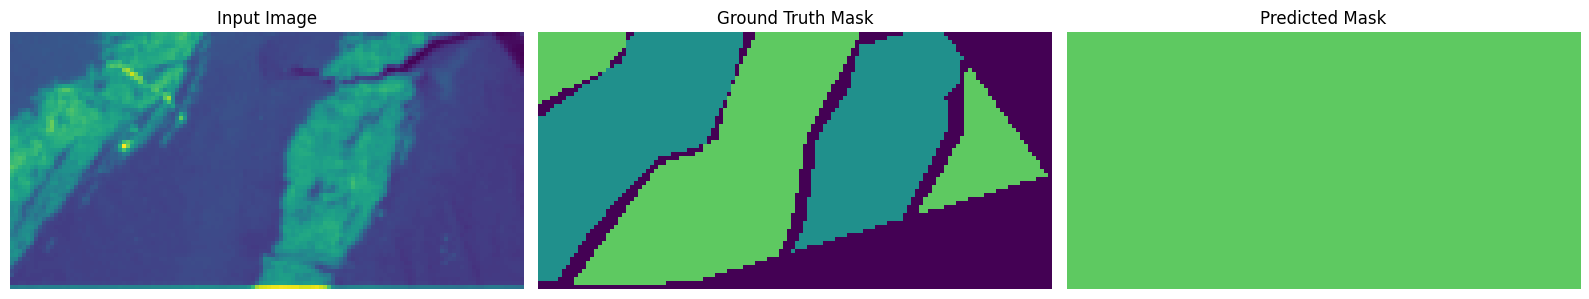

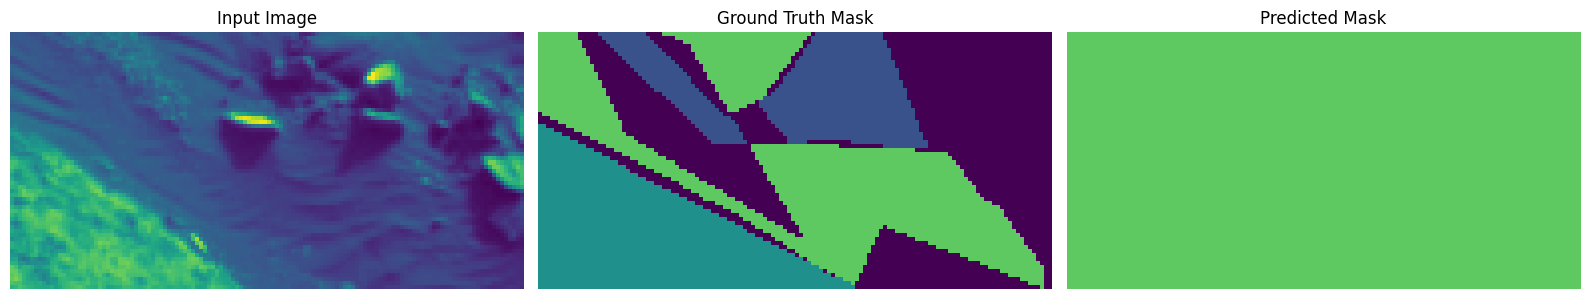

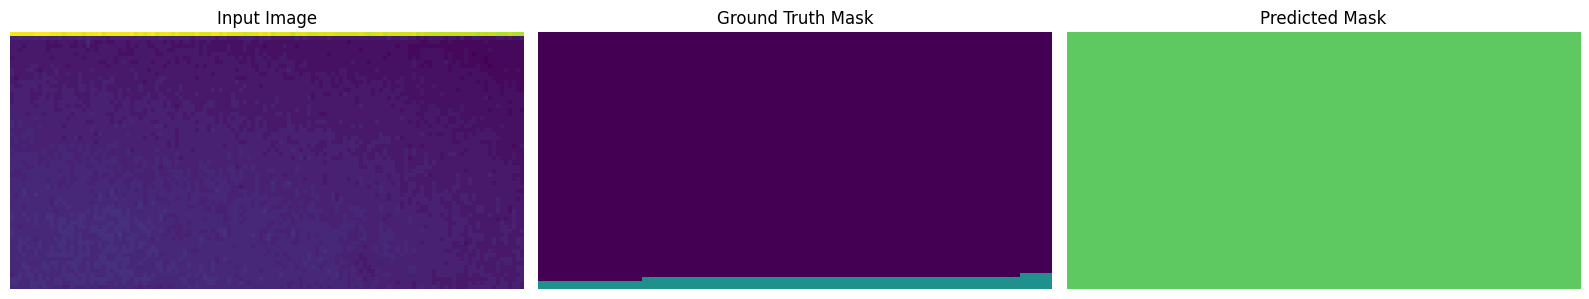

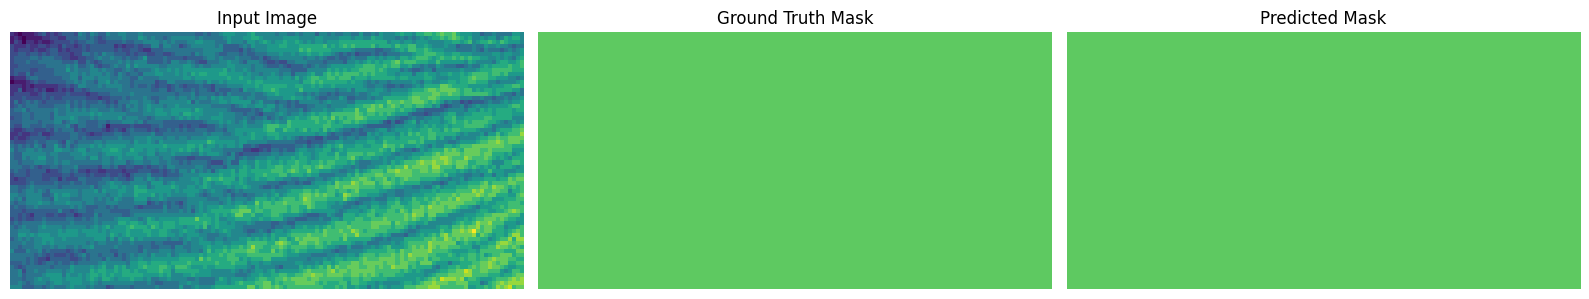

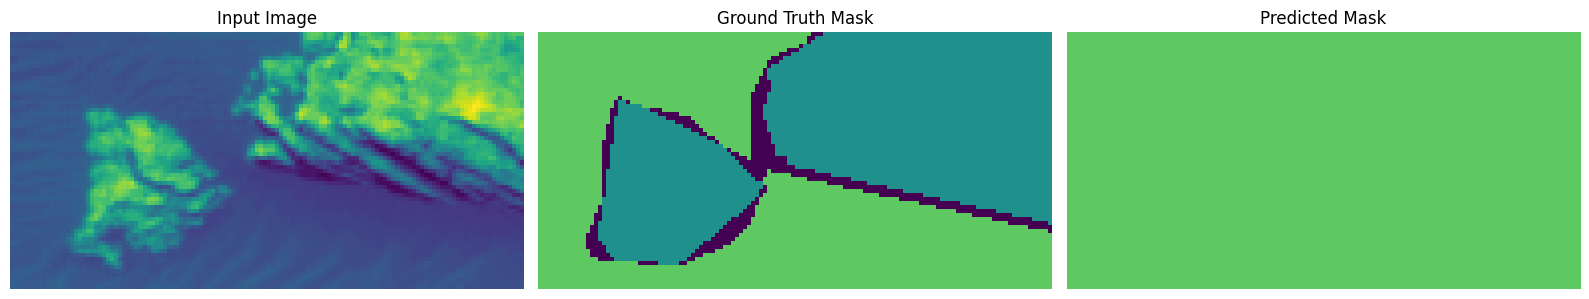

188/188 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - IoU_1: 0.3861 - IoU_2: 0.3465 - IoU_3: 0.3641 - IoU_4: 5.1469e-06 - accuracy: 0.4001 - loss: 0.1914 - mean_io_u: 0.2193 - val_IoU_1: 2.8760e-05 - val_IoU_2: 0.0000e+00 - val_IoU_3: 0.2624 - val_IoU_4: 0.0000e+00 - val_accuracy: 0.1979 - val_loss: 2.8639 - val_mean_io_u: 0.0656 - learning_rate: 0.0010
Updated class weights: {0: 0, 1: 0.26827752641760844, 2: 0.2682885486671736, 3: 0.19514537624804437, 4: 0.2682885486671736}
Epoch 2/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 111s 590ms/step - IoU_1: 0.5883 - IoU_2: 0.5399 - IoU_3: 0.5322 - IoU_4: 0.0000e+00 - accuracy: 0.5397 - loss: 0.1278 - mean_io_u: 0.4176 - val_IoU_1: 0.0225 - val_IoU_2: 0.0186 - val_IoU_3: 0.2670 - val_IoU_4: 0.0000e+00 - val_accuracy: 0.2095 - val_loss: 3.0668 - val_mean_io_u: 0.0770 - learning_rate: 0.0010
Updated class weights: {0: 0, 1: 0.2642084559532201, 2: 0.2656470790729361, 3: 0.19742486650132524, 4: 0.2727195984725184}
Epoch 3/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 111s 588ms/

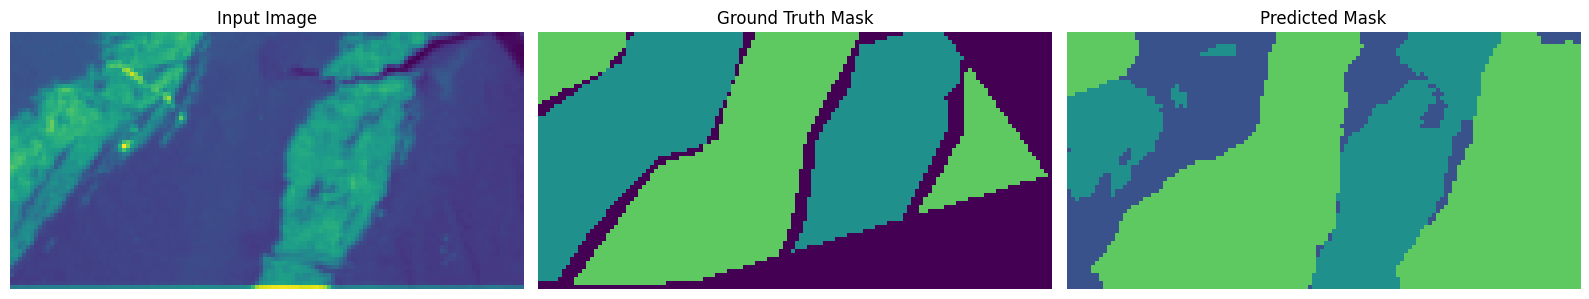

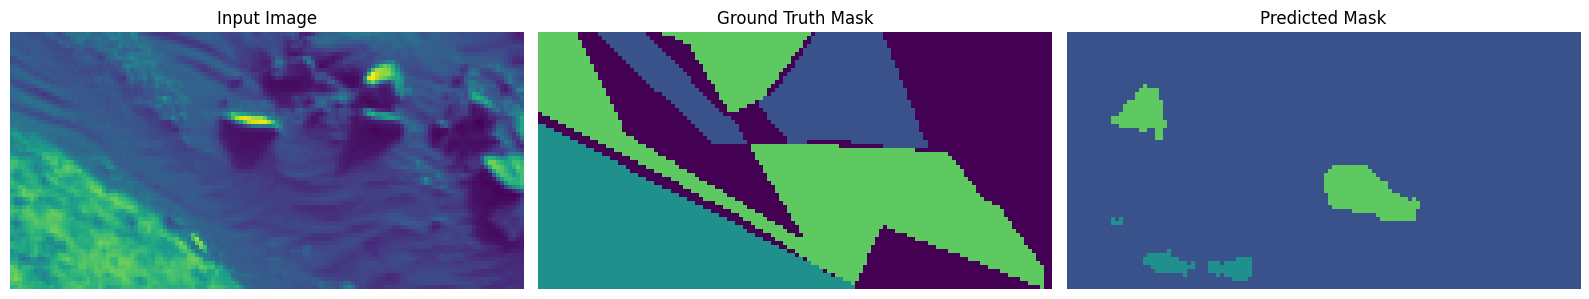

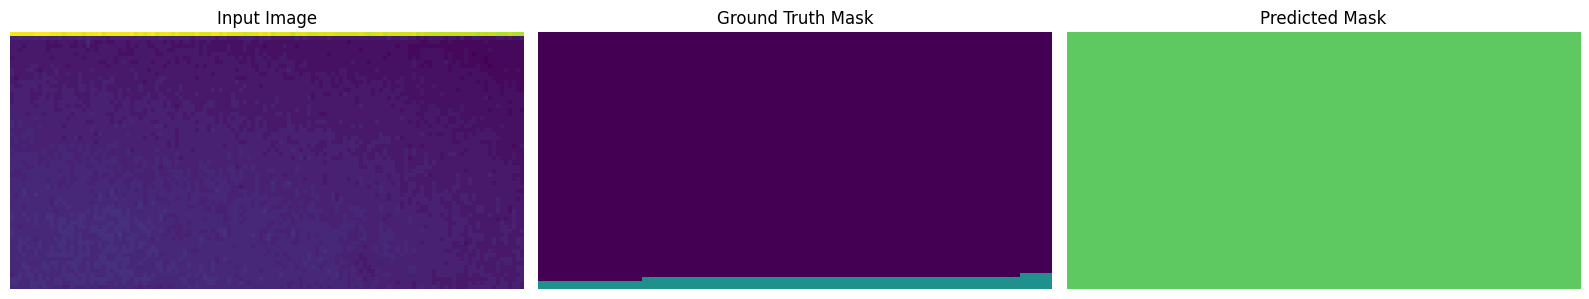

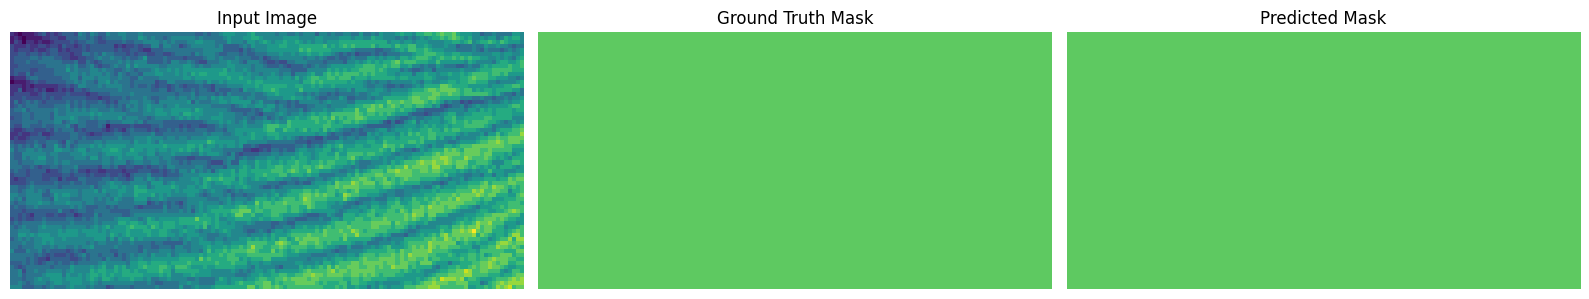

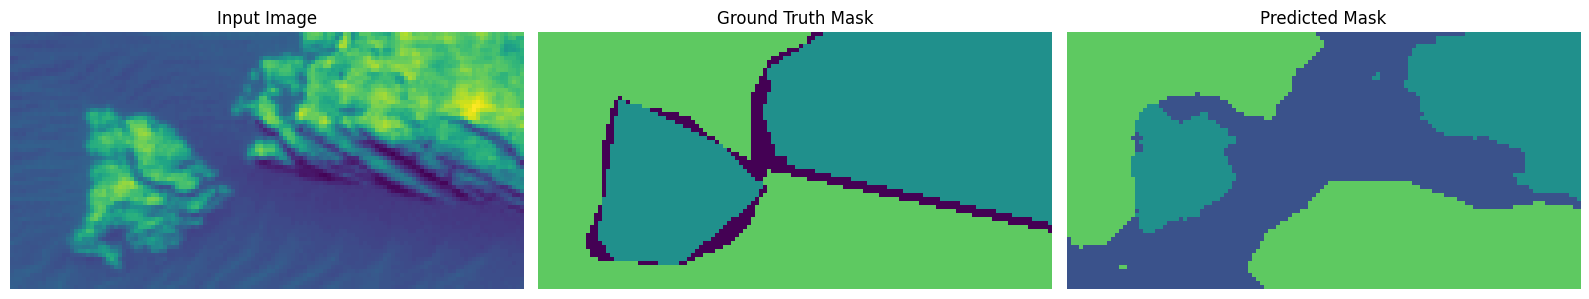

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 586ms/step - IoU_1: 0.7517 - IoU_2: 0.6783 - IoU_3: 0.7352 - IoU_4: 0.0000e+00 - accuracy: 0.6315 - loss: 0.0806 - mean_io_u: 0.5453 - val_IoU_1: 0.6263 - val_IoU_2: 0.2456 - val_IoU_3: 0.7108 - val_IoU_4: 0.0000e+00 - val_accuracy: 0.5407 - val_loss: 3.0592 - val_mean_io_u: 0.3957 - learning_rate: 0.0010
Updated class weights: {0: 0, 1: 0.19093810035179562, 2: 0.2678042198803028, 3: 0.17949406688881805, 4: 0.36176361287908354}
Epoch 7/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 111s 589ms/step - IoU_1: 0.7873 - IoU_2: 0.7251 - IoU_3: 0.7530 - IoU_4: 0.0000e+00 - accuracy: 0.6487 - loss: 0.0709 - mean_io_u: 0.5719 - val_IoU_1: 0.7690 - val_IoU_2: 0.6601 - val_IoU_3: 0.7114 - val_IoU_4: 0.0000e+00 - val_accuracy: 0.6317 - val_loss: 2.8203 - val_mean_io_u: 0.5351 - learning_rate: 0.0010
Updated class weights: {0: 0, 1: 0.19158738267761194, 2: 0.20693644453040028, 3: 0.19941297390435236, 4: 0.4020631988876355}
Epoch 8/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/st

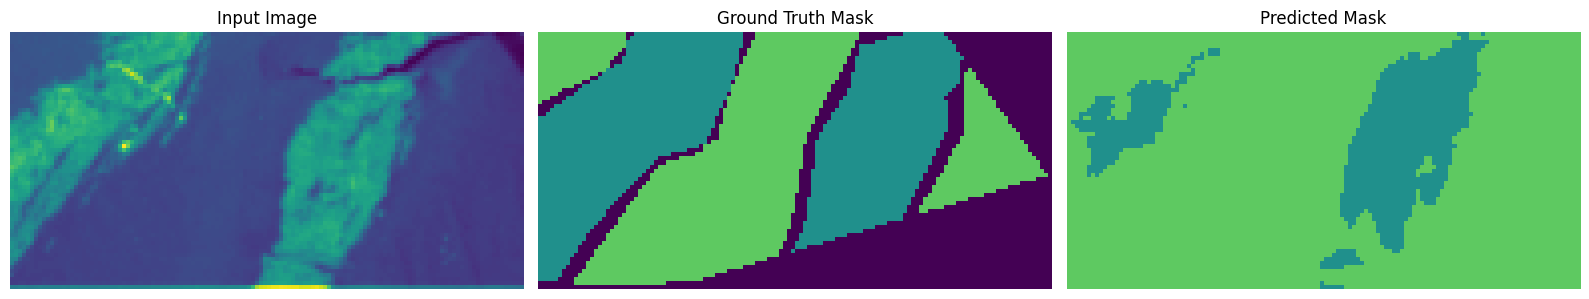

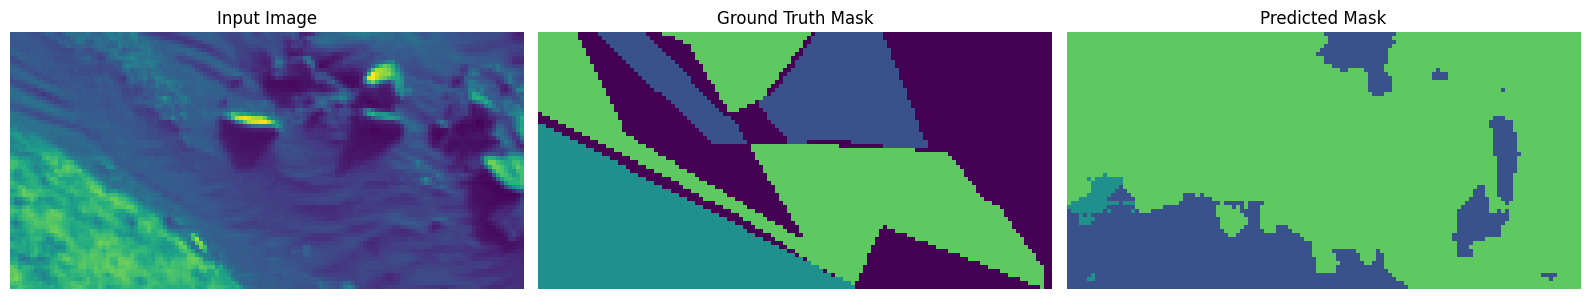

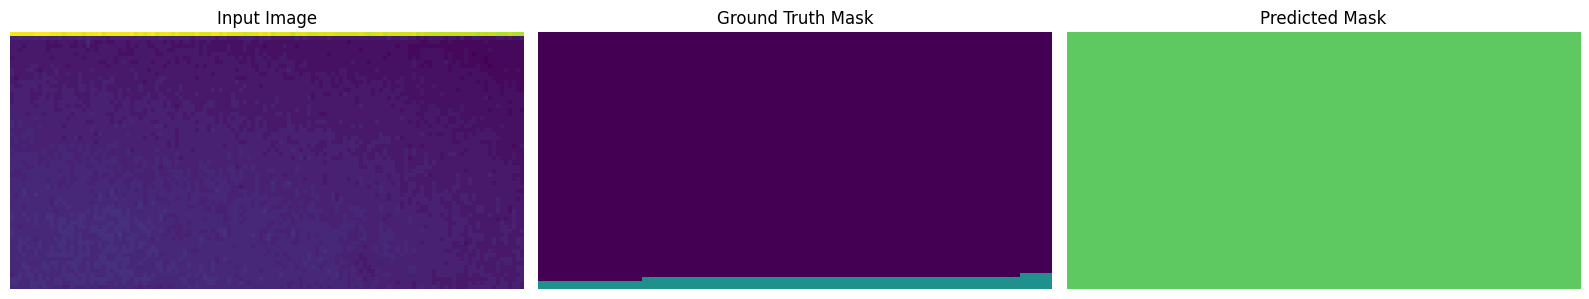

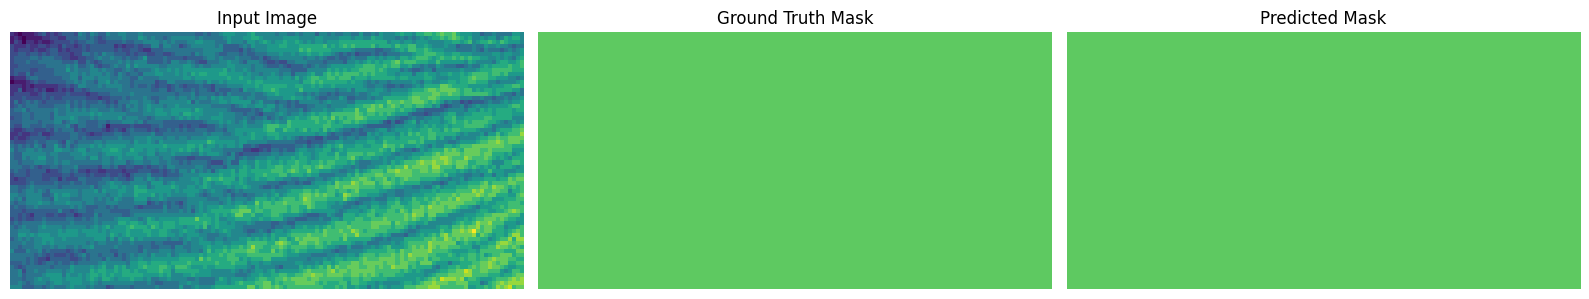

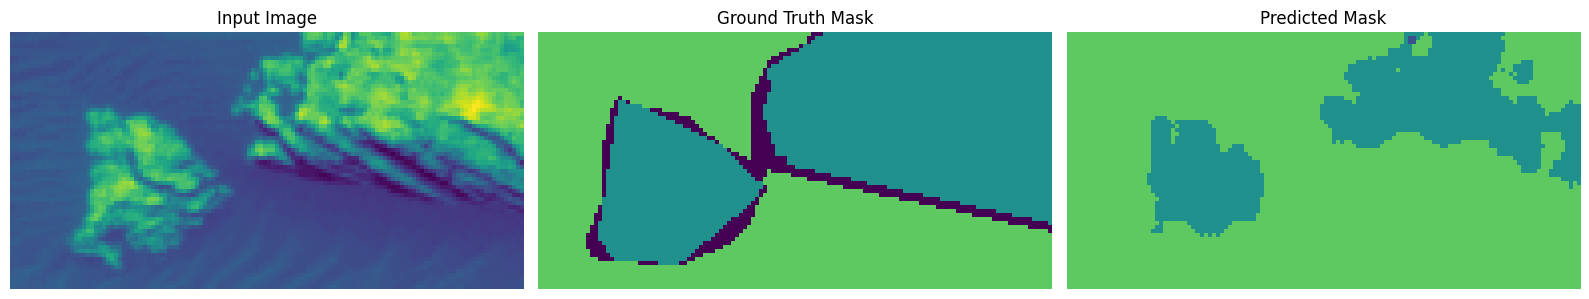

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 584ms/step - IoU_1: 0.8272 - IoU_2: 0.7650 - IoU_3: 0.7976 - IoU_4: 0.0000e+00 - accuracy: 0.6682 - loss: 0.0573 - mean_io_u: 0.6005 - val_IoU_1: 0.7489 - val_IoU_2: 0.5221 - val_IoU_3: 0.7333 - val_IoU_4: 0.0000e+00 - val_accuracy: 0.6149 - val_loss: 3.0265 - val_mean_io_u: 0.5011 - learning_rate: 0.0010
Updated class weights: {0: 0, 1: 0.18988624376142293, 2: 0.22512890845870928, 3: 0.19195367576506076, 4: 0.393031172014807}
Epoch 12/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.8290 - IoU_2: 0.7638 - IoU_3: 0.8006 - IoU_4: 0.0016 - accuracy: 0.6685 - loss: 0.0551 - mean_io_u: 0.6046 - val_IoU_1: 0.7831 - val_IoU_2: 0.5758 - val_IoU_3: 0.7690 - val_IoU_4: 0.0000e+00 - val_accuracy: 0.6325 - val_loss: 2.8016 - val_mean_io_u: 0.5320 - learning_rate: 0.0010
Updated class weights: {0: 0, 1: 0.1890052369039732, 2: 0.21971906301179045, 3: 0.19082296717488043, 4: 0.400452732909356}
Epoch 13/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - 

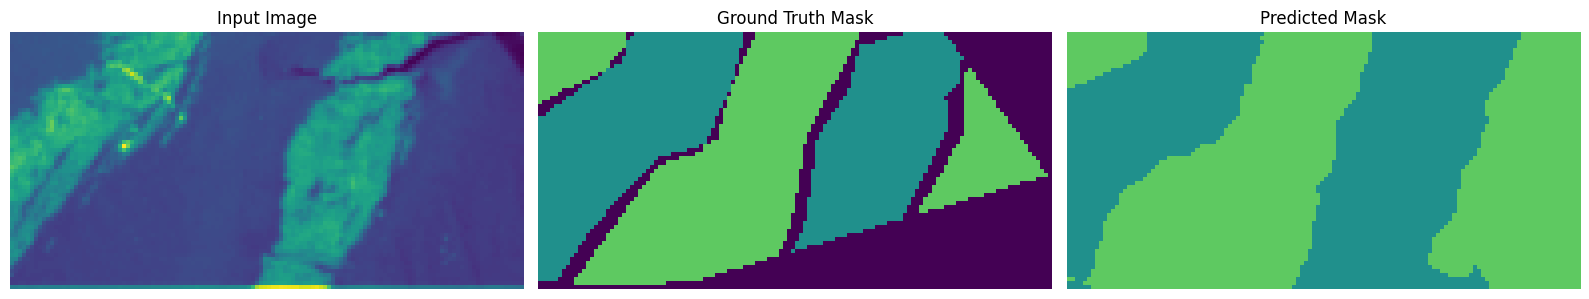

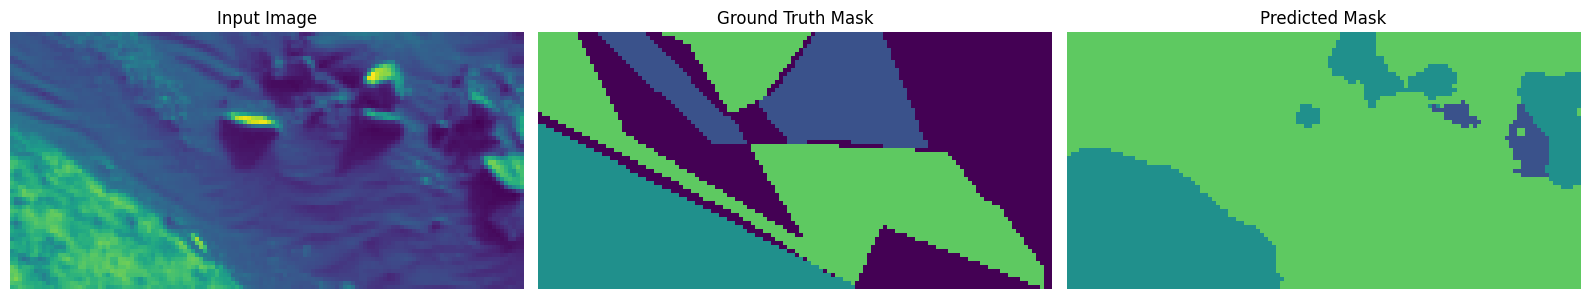

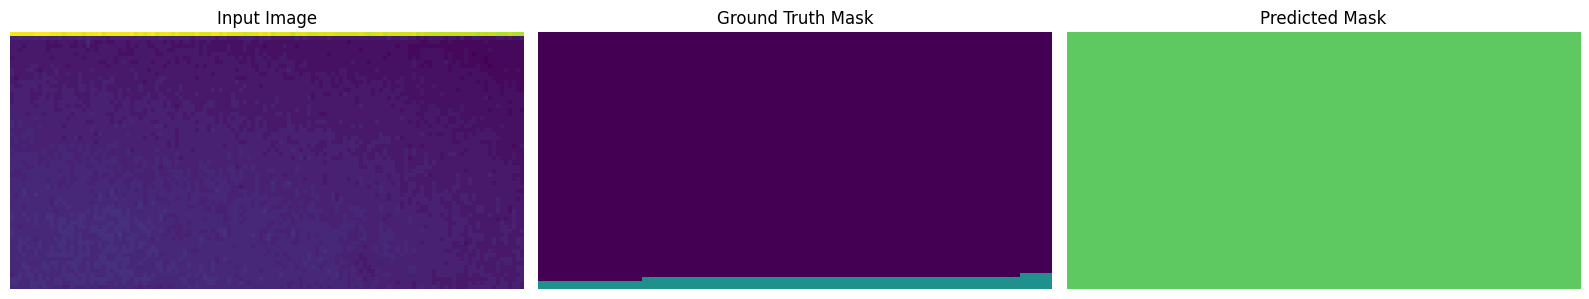

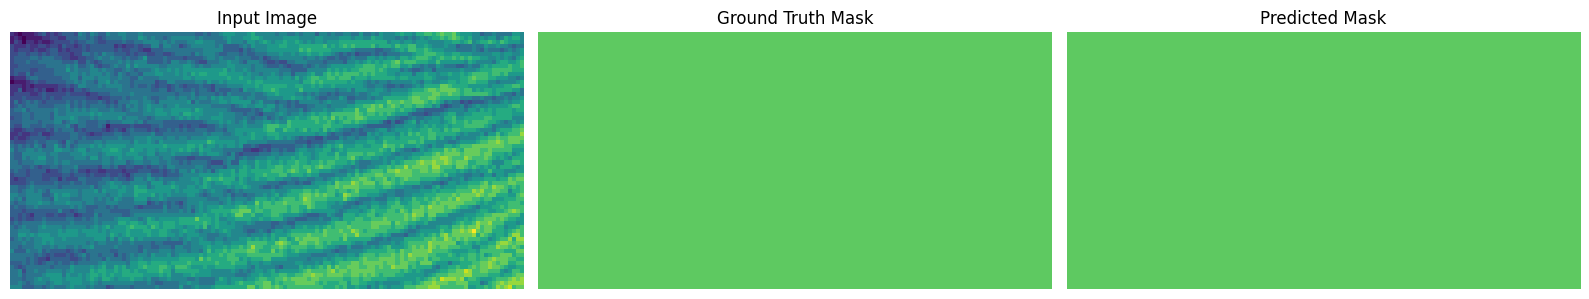

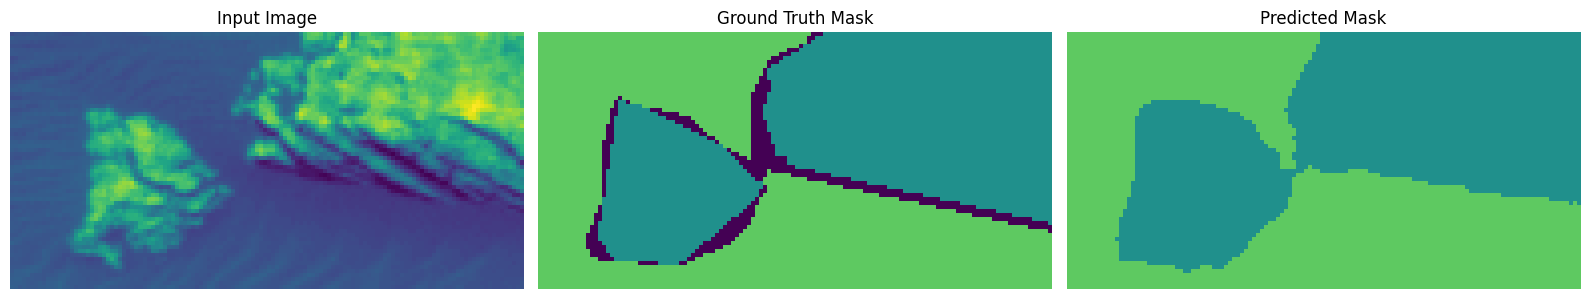

188/188 ━━━━━━━━━━━━━━━━━━━━ 113s 600ms/step - IoU_1: 0.8793 - IoU_2: 0.8227 - IoU_3: 0.8458 - IoU_4: 0.0229 - accuracy: 0.6932 - loss: 0.0429 - mean_io_u: 0.6464 - val_IoU_1: 0.8530 - val_IoU_2: 0.7276 - val_IoU_3: 0.8064 - val_IoU_4: 6.9747e-04 - val_accuracy: 0.6722 - val_loss: 2.9782 - val_mean_io_u: 0.5969 - learning_rate: 7.0000e-04
Updated class weights: {0: 0, 1: 0.1874354480189753, 2: 0.20390203868171672, 3: 0.19323422757817563, 4: 0.41542828572113244}
Epoch 17/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 585ms/step - IoU_1: 0.8694 - IoU_2: 0.8201 - IoU_3: 0.8292 - IoU_4: 0.0478 - accuracy: 0.6880 - loss: 0.0427 - mean_io_u: 0.6463 - val_IoU_1: 0.8646 - val_IoU_2: 0.7610 - val_IoU_3: 0.8261 - val_IoU_4: 1.7652e-04 - val_accuracy: 0.6814 - val_loss: 2.9174 - val_mean_io_u: 0.6130 - learning_rate: 7.0000e-04
Updated class weights: {0: 0, 1: 0.1875909508039311, 2: 0.20089416210524227, 3: 0.1923269670660023, 4: 0.41918792002482425}
Epoch 18/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/s

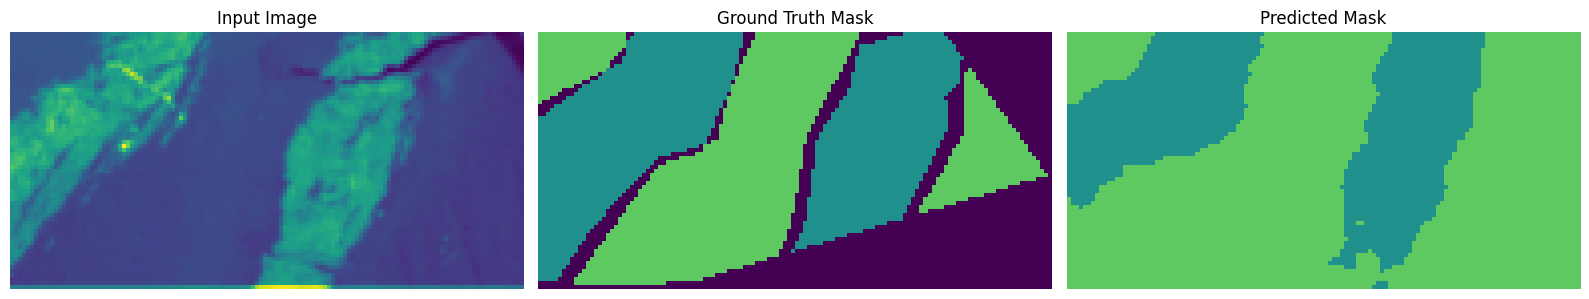

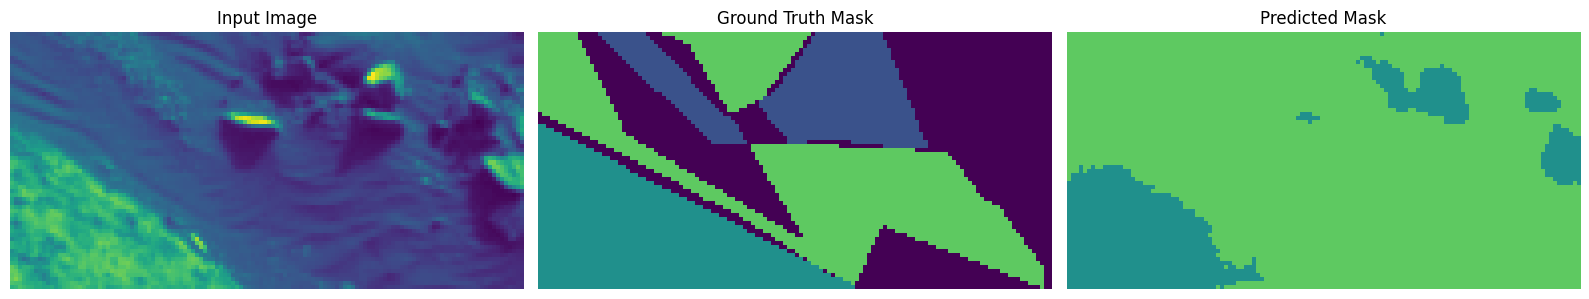

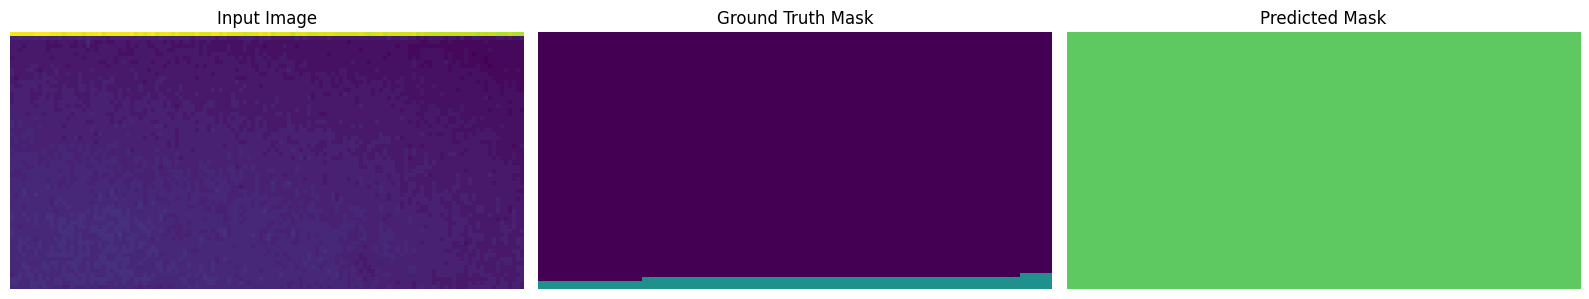

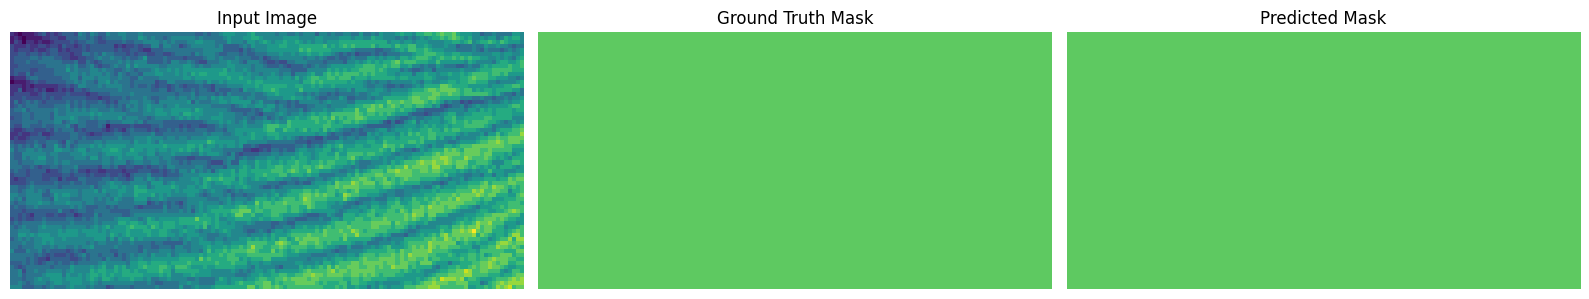

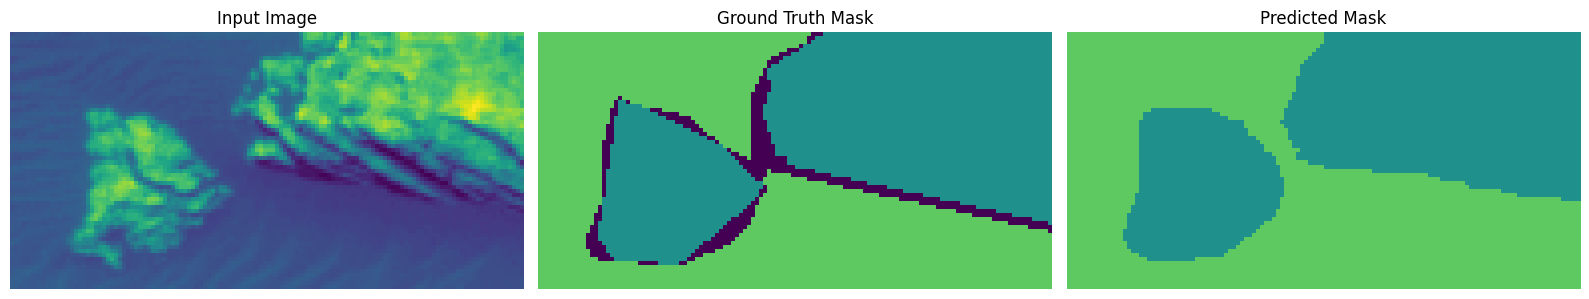

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 585ms/step - IoU_1: 0.8916 - IoU_2: 0.8462 - IoU_3: 0.8548 - IoU_4: 0.0797 - accuracy: 0.6987 - loss: 0.0359 - mean_io_u: 0.6718 - val_IoU_1: 0.8366 - val_IoU_2: 0.7360 - val_IoU_3: 0.8029 - val_IoU_4: 0.0000e+00 - val_accuracy: 0.6686 - val_loss: 3.3000 - val_mean_io_u: 0.5939 - learning_rate: 7.0000e-04
Updated class weights: {0: 0, 1: 0.18912218821620996, 2: 0.2023745628848567, 3: 0.19336041836789206, 4: 0.41514283053104123}
Epoch 22/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - IoU_1: 0.8998 - IoU_2: 0.8513 - IoU_3: 0.8634 - IoU_4: 0.0890 - accuracy: 0.7016 - loss: 0.0338 - mean_io_u: 0.6806 - val_IoU_1: 0.8309 - val_IoU_2: 0.6850 - val_IoU_3: 0.8292 - val_IoU_4: 0.0764 - val_accuracy: 0.6657 - val_loss: 3.2095 - val_mean_io_u: 0.6054 - learning_rate: 7.0000e-04
Updated class weights: {0: 0, 1: 0.19691581803917968, 2: 0.2176539286293178, 3: 0.19713364466700464, 4: 0.3882966086644979}
Epoch 23/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step 

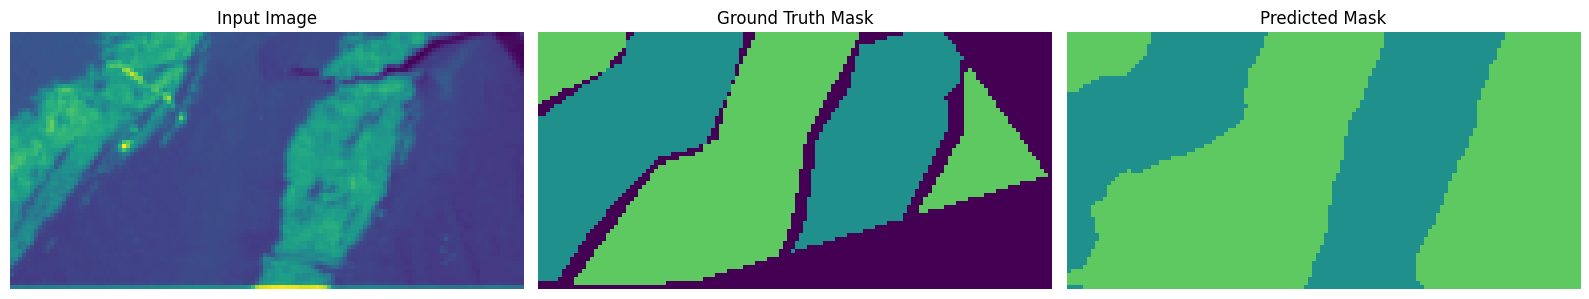

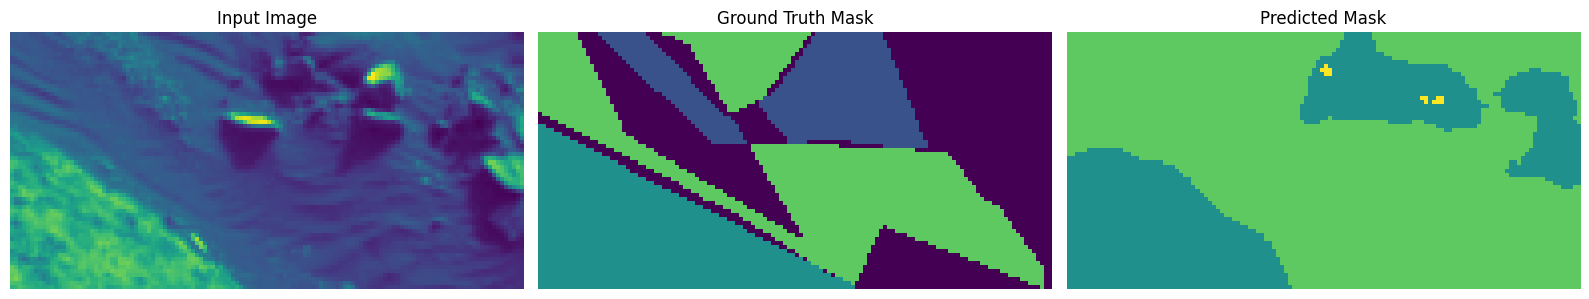

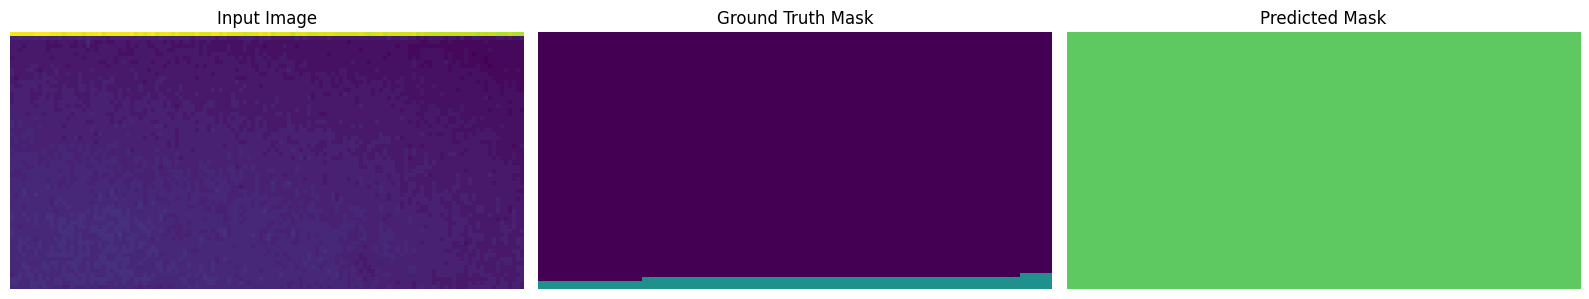

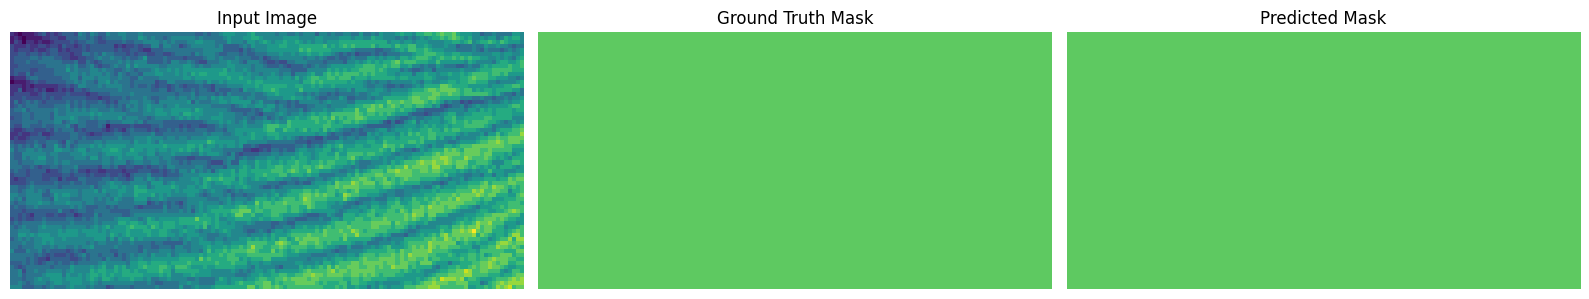

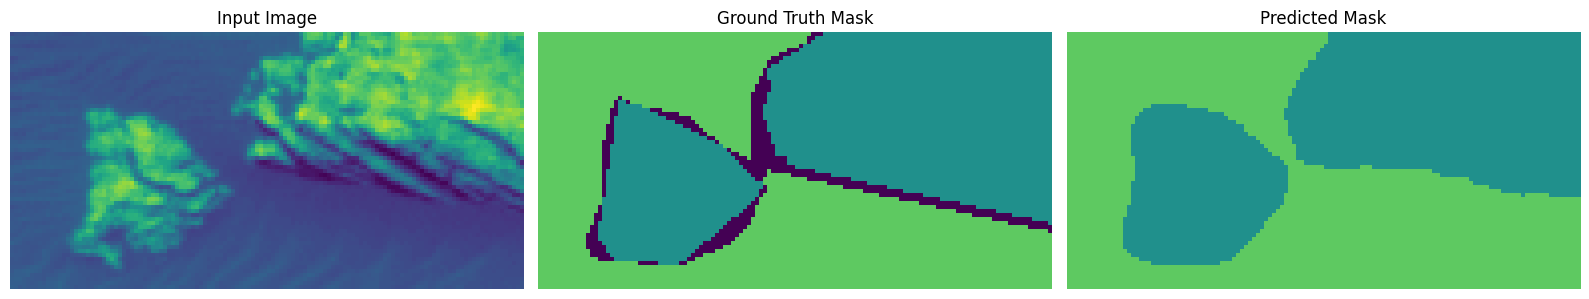

188/188 ━━━━━━━━━━━━━━━━━━━━ 112s 596ms/step - IoU_1: 0.9220 - IoU_2: 0.8752 - IoU_3: 0.8973 - IoU_4: 0.0862 - accuracy: 0.7124 - loss: 0.0285 - mean_io_u: 0.7000 - val_IoU_1: 0.8656 - val_IoU_2: 0.7616 - val_IoU_3: 0.8490 - val_IoU_4: 0.0181 - val_accuracy: 0.6837 - val_loss: 3.2886 - val_mean_io_u: 0.6236 - learning_rate: 4.9000e-04
Updated class weights: {0: 0, 1: 0.19004175938086565, 2: 0.20356370917983974, 3: 0.19207798921109256, 4: 0.414316542228202}
Epoch 27/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9247 - IoU_2: 0.8836 - IoU_3: 0.9135 - IoU_4: 0.1234 - accuracy: 0.7152 - loss: 0.0260 - mean_io_u: 0.7113 - val_IoU_1: 0.8720 - val_IoU_2: 0.7762 - val_IoU_3: 0.8395 - val_IoU_4: 0.0030 - val_accuracy: 0.6861 - val_loss: 3.2313 - val_mean_io_u: 0.6227 - learning_rate: 4.9000e-04
Updated class weights: {0: 0, 1: 0.18789078779157634, 2: 0.20009584059010016, 3: 0.19185891712256764, 4: 0.42015445449575584}
Epoch 28/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 587ms/step - I

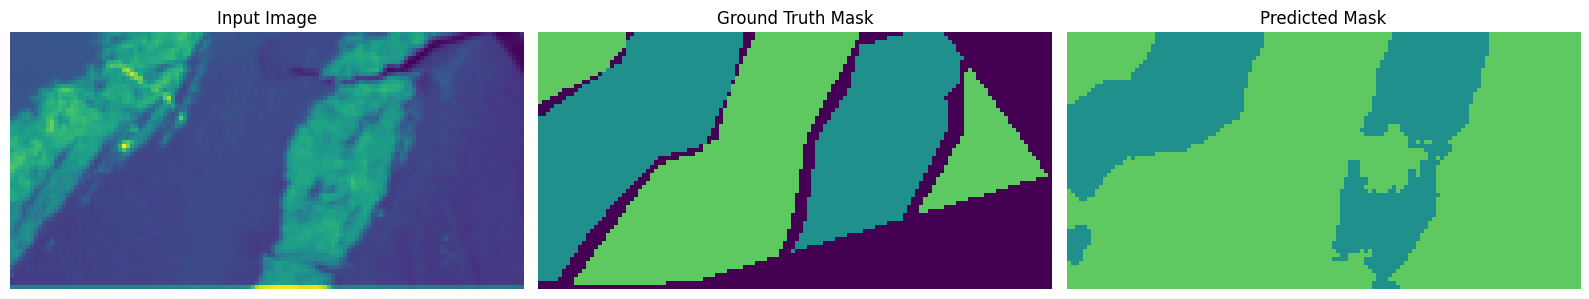

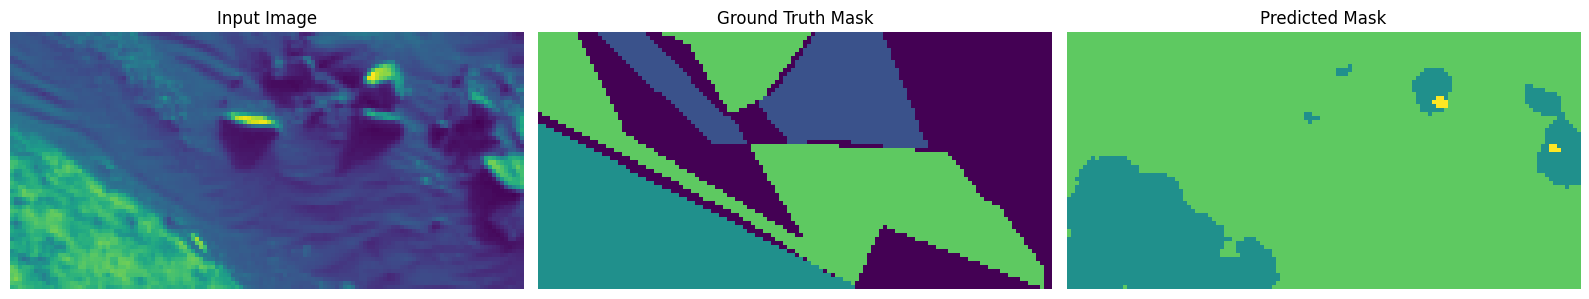

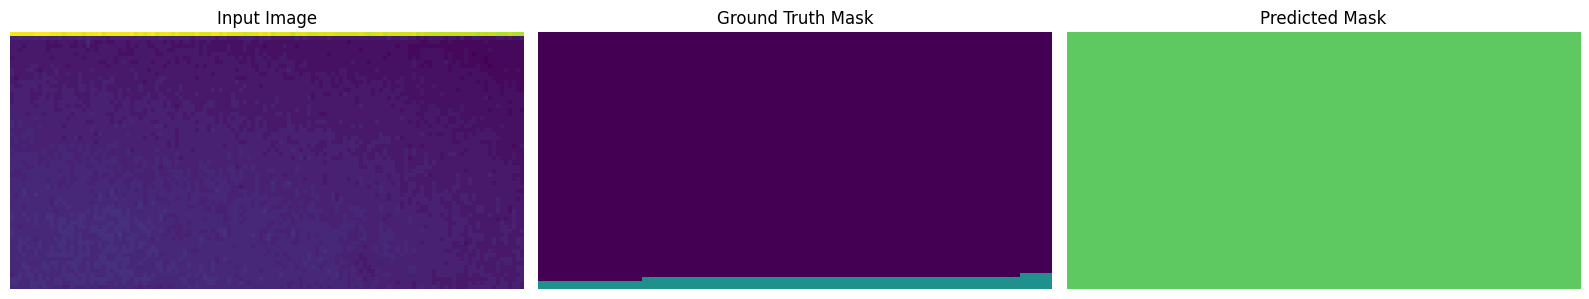

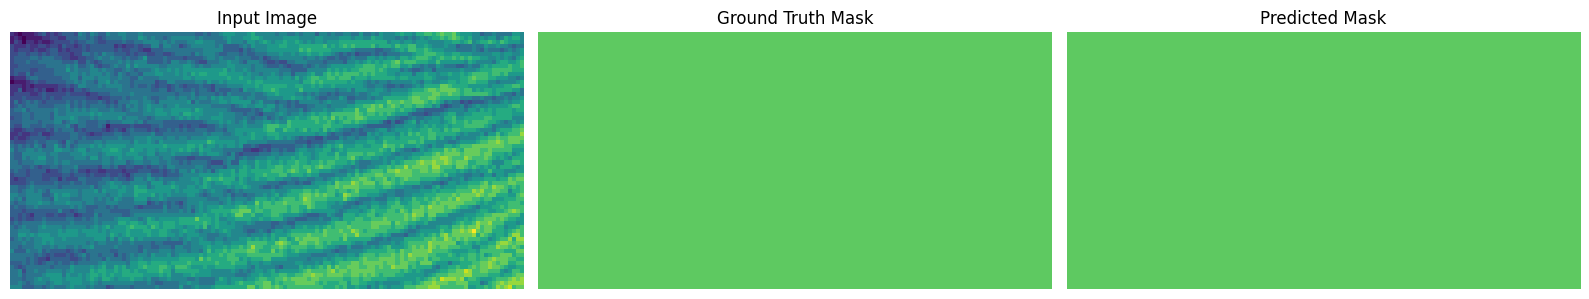

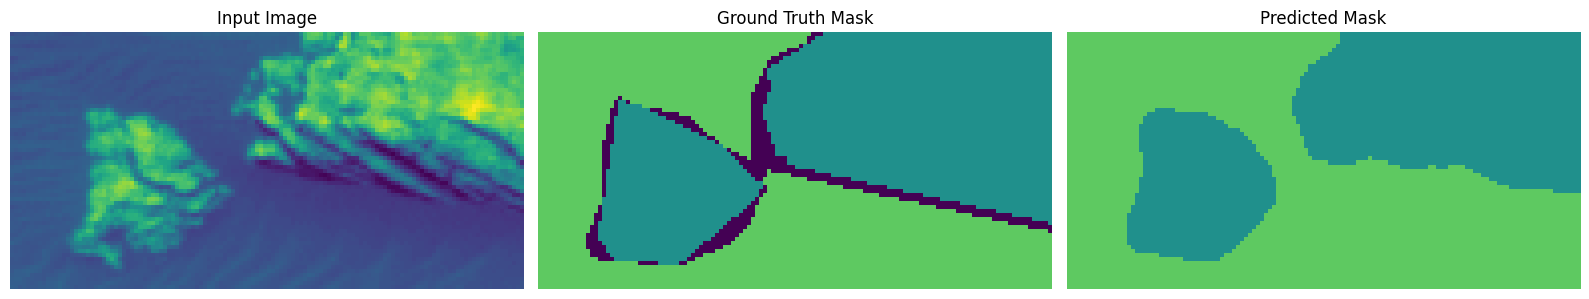

188/188 ━━━━━━━━━━━━━━━━━━━━ 112s 595ms/step - IoU_1: 0.9377 - IoU_2: 0.9001 - IoU_3: 0.9146 - IoU_4: 0.1824 - accuracy: 0.7208 - loss: 0.0230 - mean_io_u: 0.7337 - val_IoU_1: 0.8964 - val_IoU_2: 0.7515 - val_IoU_3: 0.8020 - val_IoU_4: 0.0523 - val_accuracy: 0.6831 - val_loss: 3.2794 - val_mean_io_u: 0.6255 - learning_rate: 4.9000e-04
Updated class weights: {0: 0, 1: 0.18922471205881447, 2: 0.20811414177512302, 3: 0.20112177145569865, 4: 0.4015393747103637}
Epoch 32/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 585ms/step - IoU_1: 0.9365 - IoU_2: 0.9027 - IoU_3: 0.9214 - IoU_4: 0.2158 - accuracy: 0.7217 - loss: 0.0223 - mean_io_u: 0.7453 - val_IoU_1: 0.8747 - val_IoU_2: 0.7505 - val_IoU_3: 0.8282 - val_IoU_4: 0.0704 - val_accuracy: 0.6823 - val_loss: 3.4205 - val_mean_io_u: 0.6310 - learning_rate: 4.9000e-04
Updated class weights: {0: 0, 1: 0.19378874553664435, 2: 0.21038517278910449, 3: 0.19968846424512698, 4: 0.3961376174291242}
Epoch 33/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - I

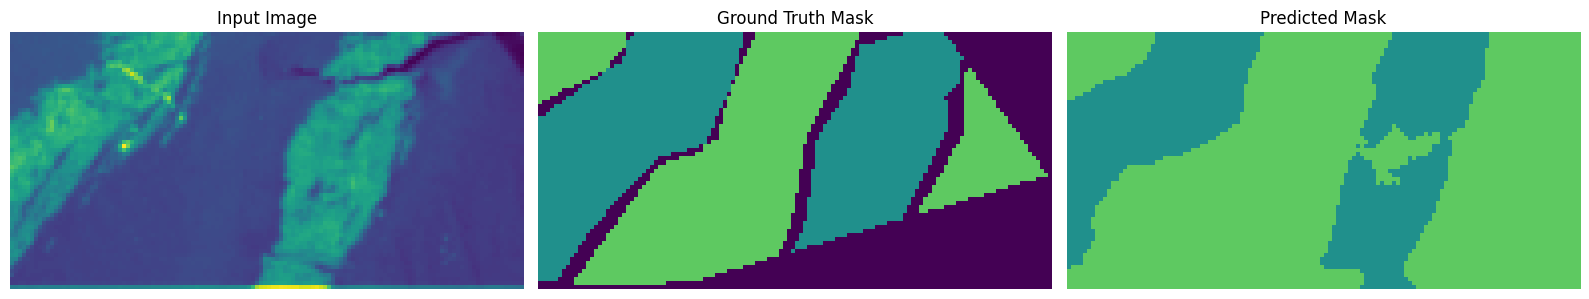

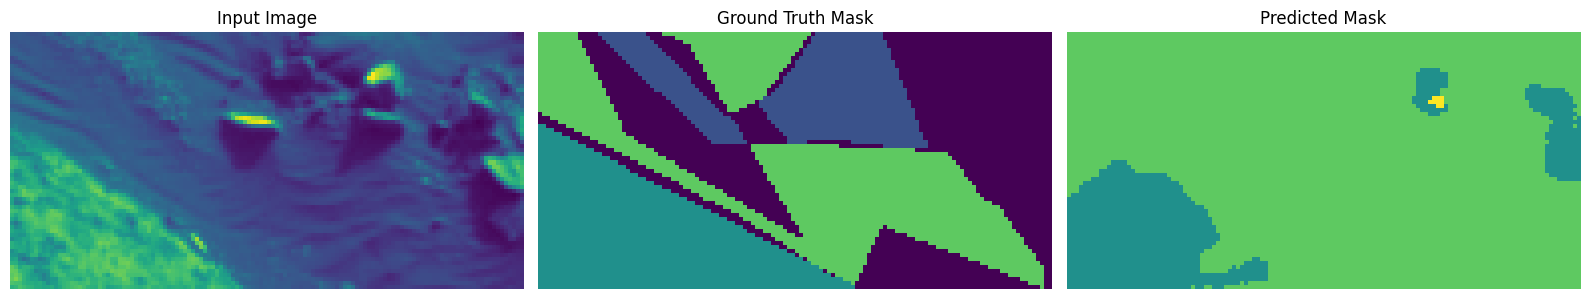

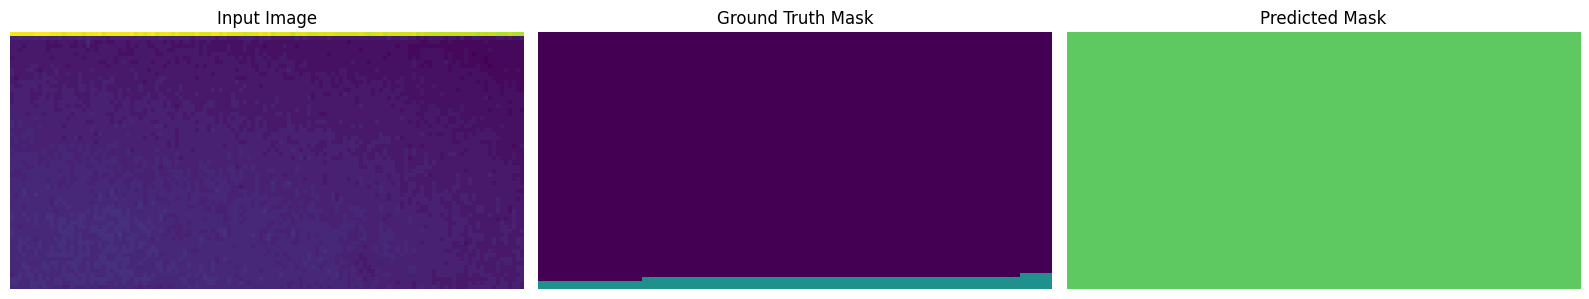

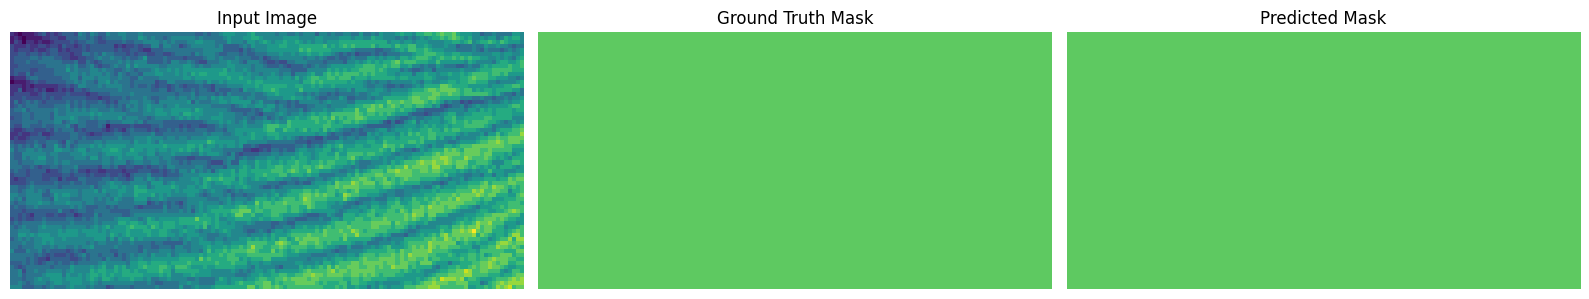

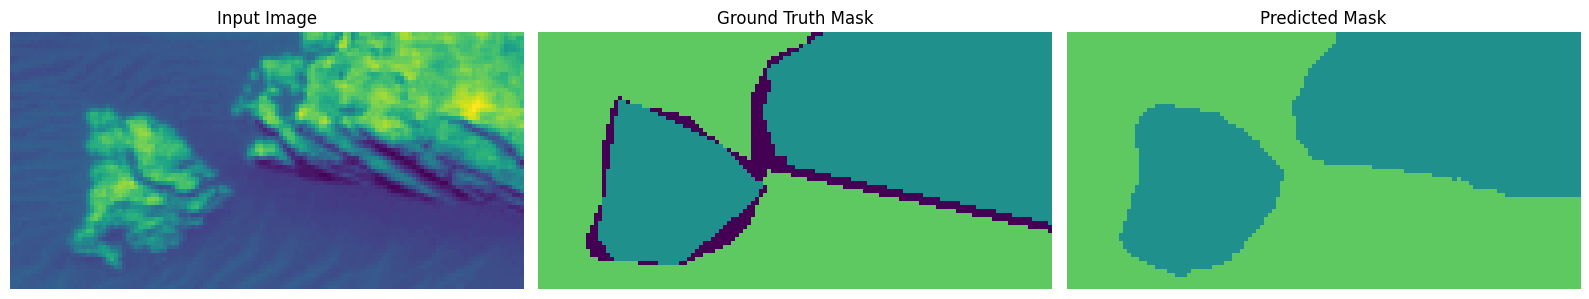

188/188 ━━━━━━━━━━━━━━━━━━━━ 112s 596ms/step - IoU_1: 0.9497 - IoU_2: 0.9177 - IoU_3: 0.9315 - IoU_4: 0.3247 - accuracy: 0.7271 - loss: 0.0195 - mean_io_u: 0.7809 - val_IoU_1: 0.8909 - val_IoU_2: 0.7756 - val_IoU_3: 0.8317 - val_IoU_4: 0.2998 - val_accuracy: 0.6893 - val_loss: 3.4065 - val_mean_io_u: 0.6995 - learning_rate: 3.4300e-04
Updated class weights: {0: 0, 1: 0.21240478317628217, 2: 0.22899401308076187, 3: 0.220613294300494, 4: 0.337987909442462}
Epoch 37/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9440 - IoU_2: 0.9155 - IoU_3: 0.9287 - IoU_4: 0.3223 - accuracy: 0.7252 - loss: 0.0198 - mean_io_u: 0.7776 - val_IoU_1: 0.8729 - val_IoU_2: 0.7517 - val_IoU_3: 0.8540 - val_IoU_4: 0.2540 - val_accuracy: 0.6854 - val_loss: 3.5709 - val_mean_io_u: 0.6831 - learning_rate: 3.4300e-04
Updated class weights: {0: 0, 1: 0.21077681853893704, 2: 0.22837460884579633, 3: 0.21333990304247505, 4: 0.34750866957279153}
Epoch 38/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU

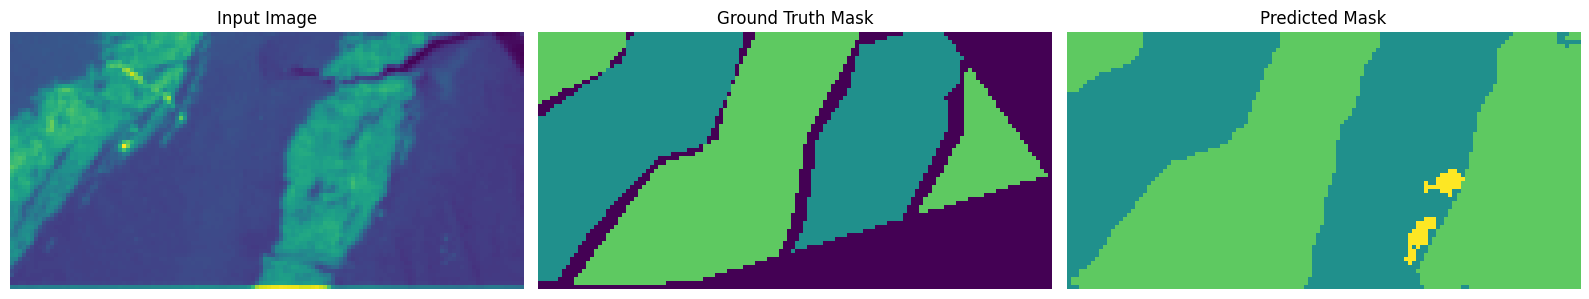

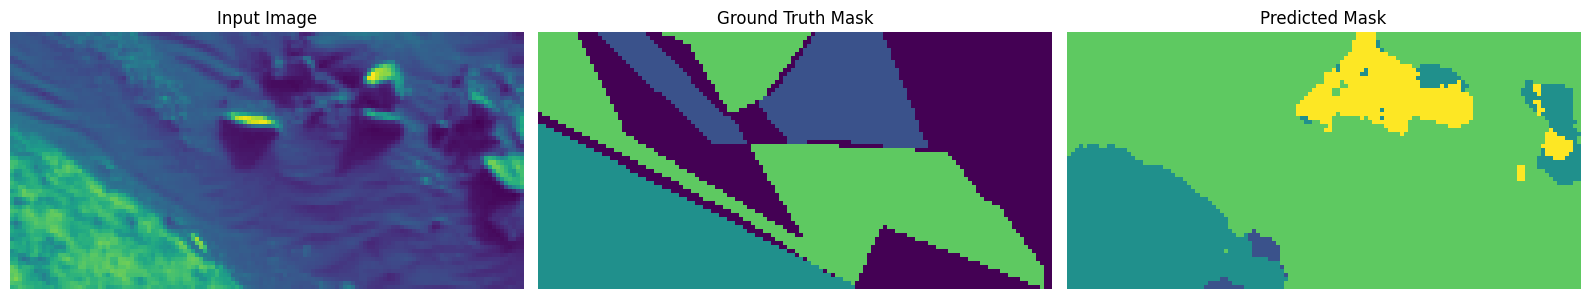

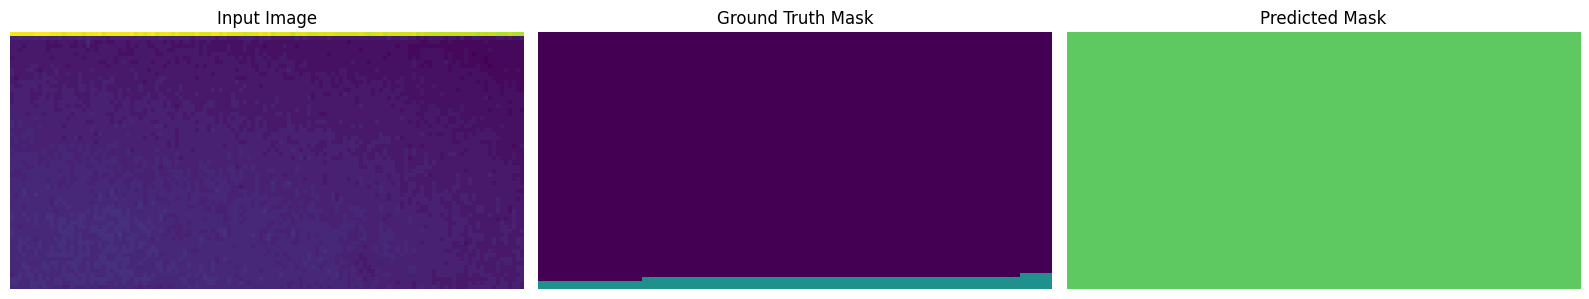

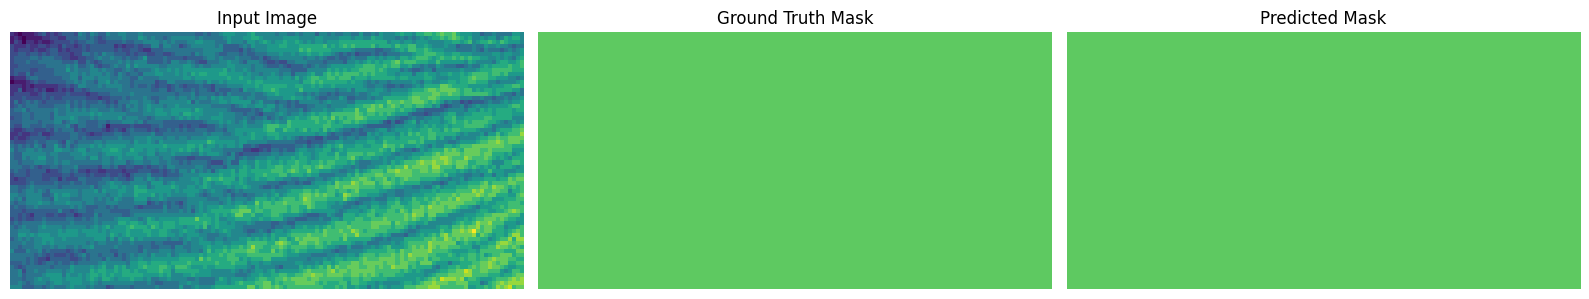

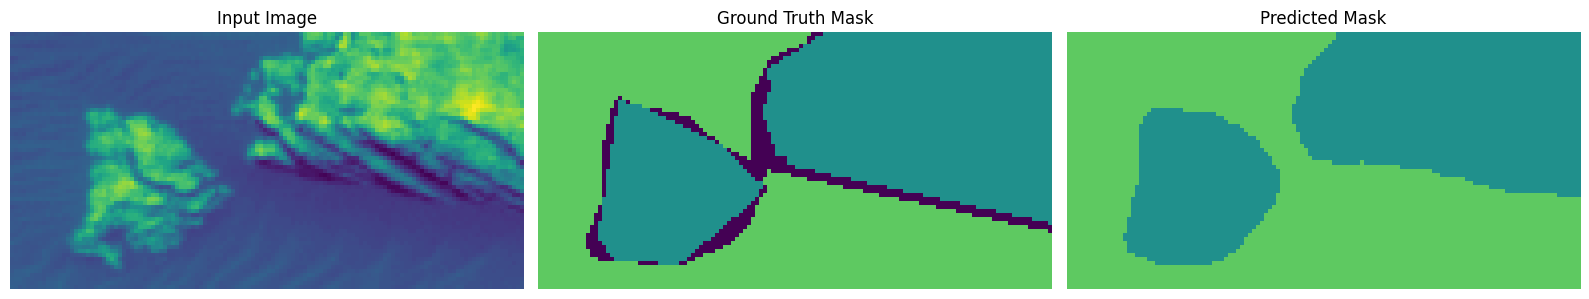

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 585ms/step - IoU_1: 0.9512 - IoU_2: 0.9208 - IoU_3: 0.9349 - IoU_4: 0.3685 - accuracy: 0.7282 - loss: 0.0178 - mean_io_u: 0.7938 - val_IoU_1: 0.8790 - val_IoU_2: 0.7664 - val_IoU_3: 0.8520 - val_IoU_4: 0.2022 - val_accuracy: 0.6878 - val_loss: 3.4757 - val_mean_io_u: 0.6749 - learning_rate: 3.4300e-04
Updated class weights: {0: 0, 1: 0.2064312401060691, 2: 0.22228130823388673, 3: 0.21001731160529702, 4: 0.3612701400547471}
Epoch 42/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9538 - IoU_2: 0.9237 - IoU_3: 0.9372 - IoU_4: 0.3576 - accuracy: 0.7291 - loss: 0.0174 - mean_io_u: 0.7931 - val_IoU_1: 0.8352 - val_IoU_2: 0.7325 - val_IoU_3: 0.8484 - val_IoU_4: 0.0661 - val_accuracy: 0.6727 - val_loss: 3.7667 - val_mean_io_u: 0.6205 - learning_rate: 3.4300e-04
Updated class weights: {0: 0, 1: 0.1973543621829338, 2: 0.21150444302012392, 3: 0.1956605341784616, 4: 0.3954806606184807}
Epoch 43/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_

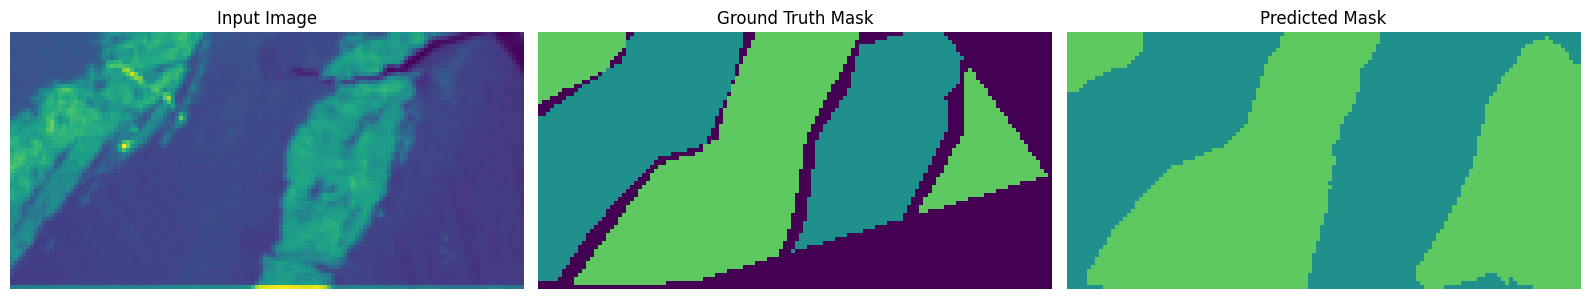

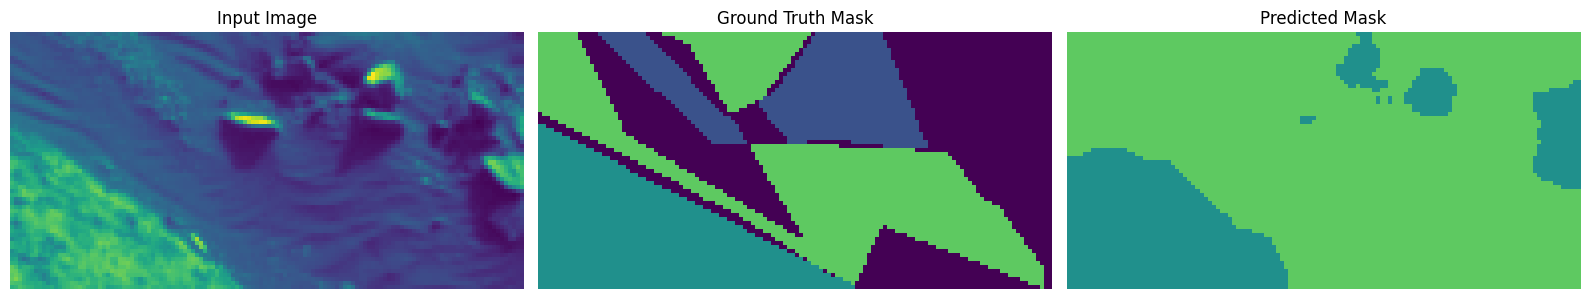

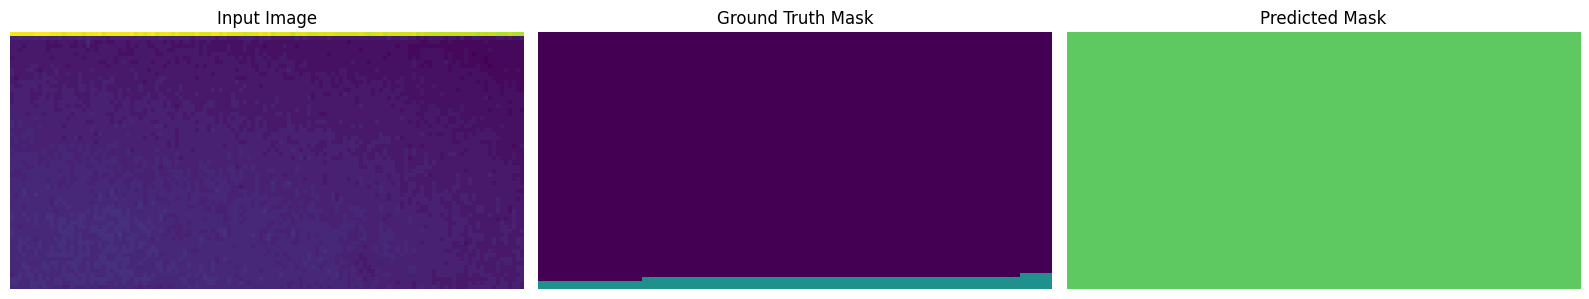

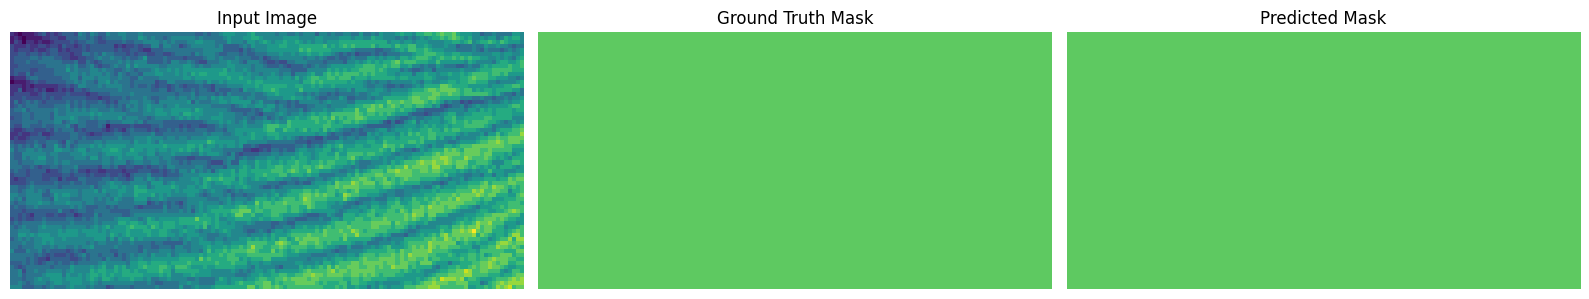

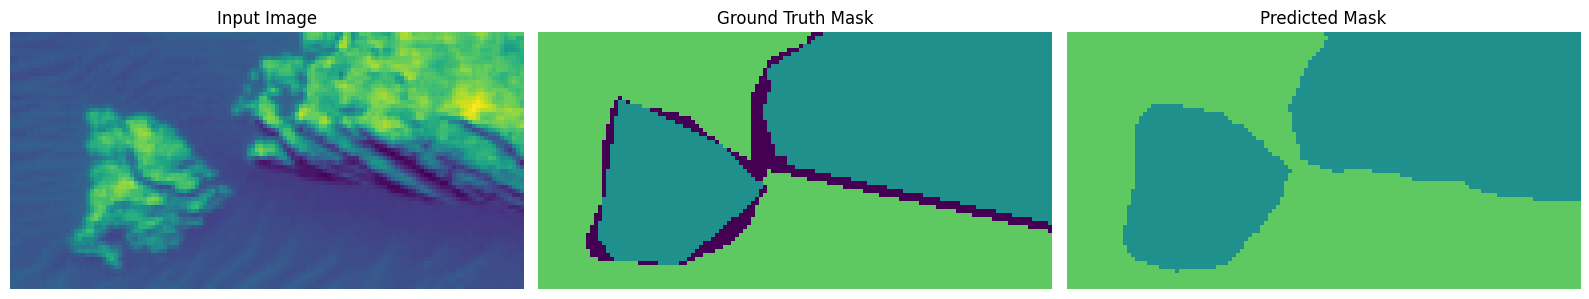

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 587ms/step - IoU_1: 0.9571 - IoU_2: 0.9352 - IoU_3: 0.9409 - IoU_4: 0.4151 - accuracy: 0.7312 - loss: 0.0157 - mean_io_u: 0.8160 - val_IoU_1: 0.8573 - val_IoU_2: 0.7444 - val_IoU_3: 0.8365 - val_IoU_4: 0.1522 - val_accuracy: 0.6772 - val_loss: 3.9260 - val_mean_io_u: 0.6476 - learning_rate: 2.4010e-04
Updated class weights: {0: 0, 1: 0.20328706859400766, 2: 0.21917777523697488, 3: 0.20603718602868726, 4: 0.37149797014033015}
Epoch 47/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9608 - IoU_2: 0.9324 - IoU_3: 0.9453 - IoU_4: 0.4536 - accuracy: 0.7322 - loss: 0.0155 - mean_io_u: 0.8256 - val_IoU_1: 0.8960 - val_IoU_2: 0.7940 - val_IoU_3: 0.8538 - val_IoU_4: 0.1026 - val_accuracy: 0.6947 - val_loss: 3.7917 - val_mean_io_u: 0.6616 - learning_rate: 2.4010e-04
Updated class weights: {0: 0, 1: 0.1966900735412845, 2: 0.21012278831500694, 3: 0.20203165829369038, 4: 0.39115547985001825}
Epoch 48/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - 

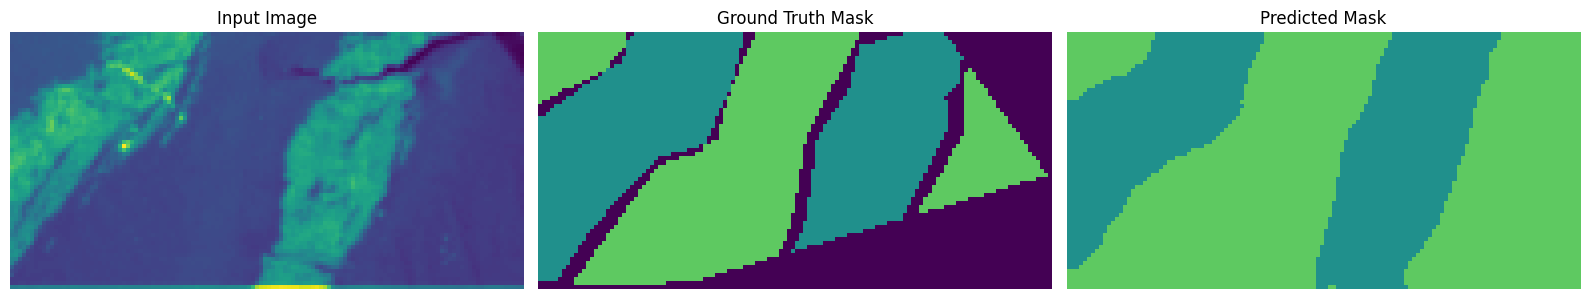

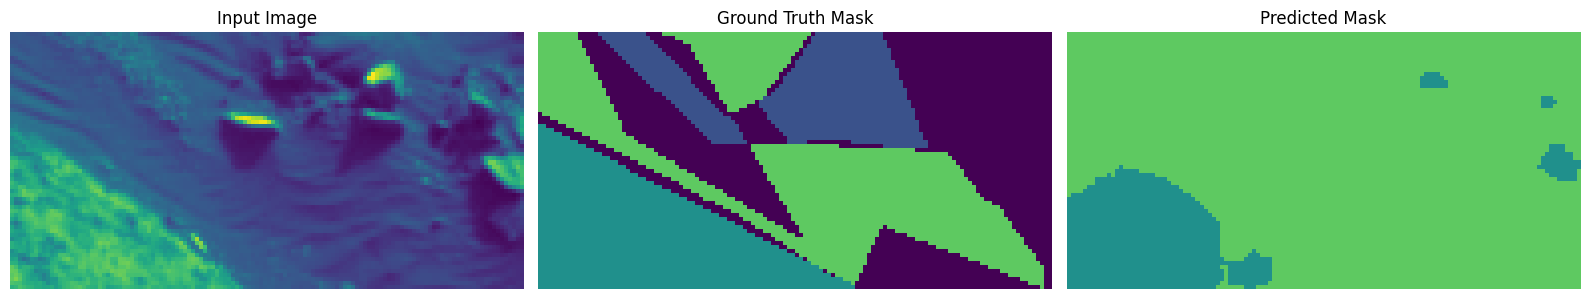

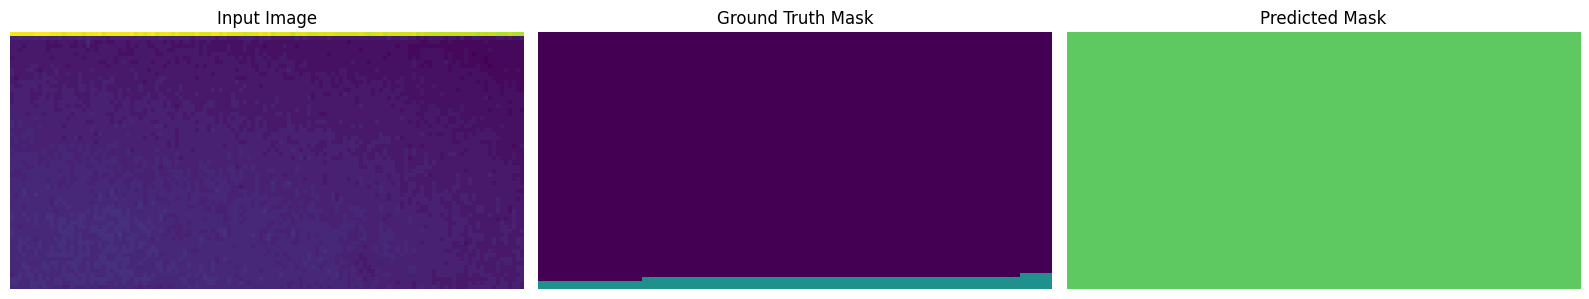

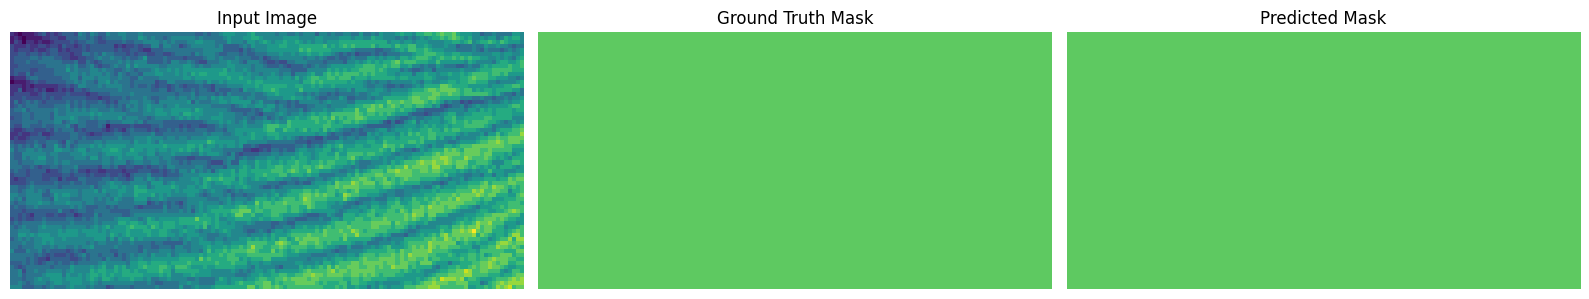

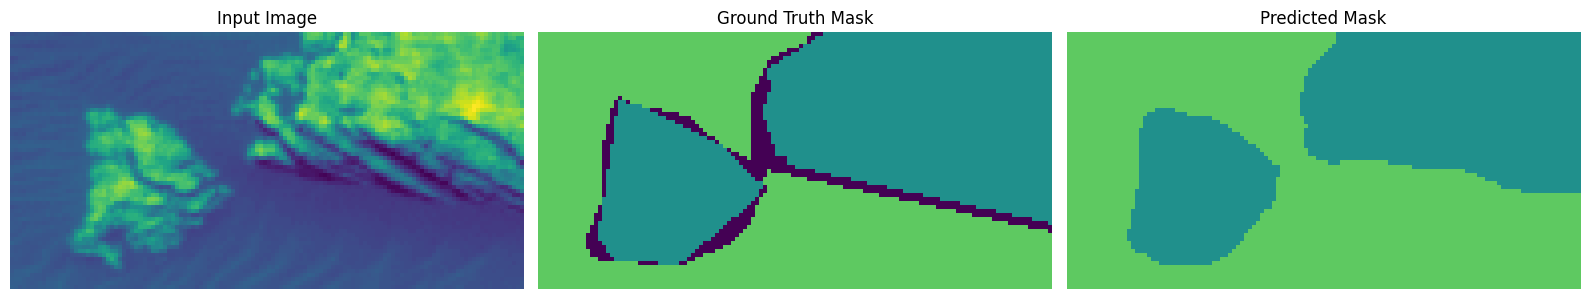

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 584ms/step - IoU_1: 0.9659 - IoU_2: 0.9433 - IoU_3: 0.9491 - IoU_4: 0.5298 - accuracy: 0.7343 - loss: 0.0133 - mean_io_u: 0.8470 - val_IoU_1: 0.8457 - val_IoU_2: 0.7105 - val_IoU_3: 0.8459 - val_IoU_4: 0.1978 - val_accuracy: 0.6742 - val_loss: 4.0637 - val_mean_io_u: 0.6500 - learning_rate: 2.4010e-04
Updated class weights: {0: 0, 1: 0.20758654837073098, 2: 0.22748801791251216, 3: 0.20755441357867097, 4: 0.35737102013808586}
Epoch 52/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9634 - IoU_2: 0.9429 - IoU_3: 0.9501 - IoU_4: 0.5019 - accuracy: 0.7338 - loss: 0.0134 - mean_io_u: 0.8473 - val_IoU_1: 0.8727 - val_IoU_2: 0.7490 - val_IoU_3: 0.8486 - val_IoU_4: 0.2697 - val_accuracy: 0.6846 - val_loss: 3.9271 - val_mean_io_u: 0.6850 - learning_rate: 2.4010e-04
Updated class weights: {0: 0, 1: 0.21174378767759974, 2: 0.22981603435593162, 3: 0.21503810155455466, 4: 0.34340207641191395}
Epoch 53/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 586ms/step -

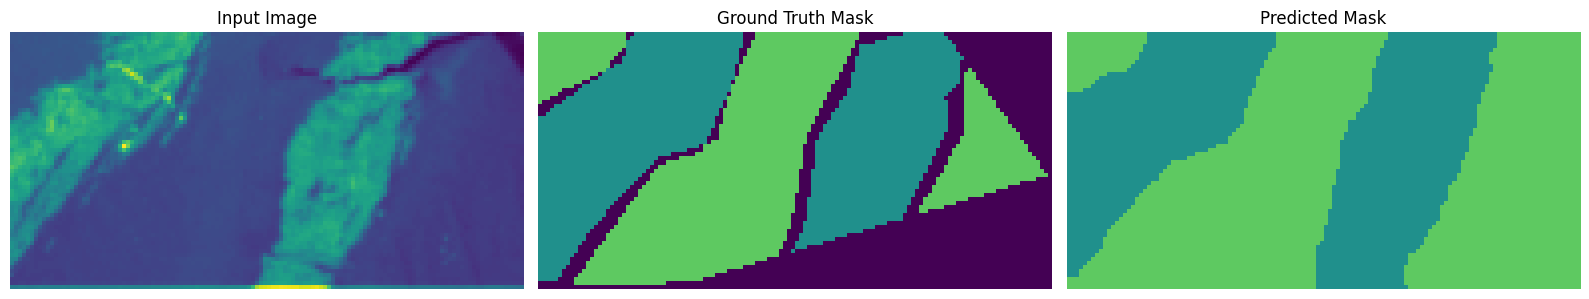

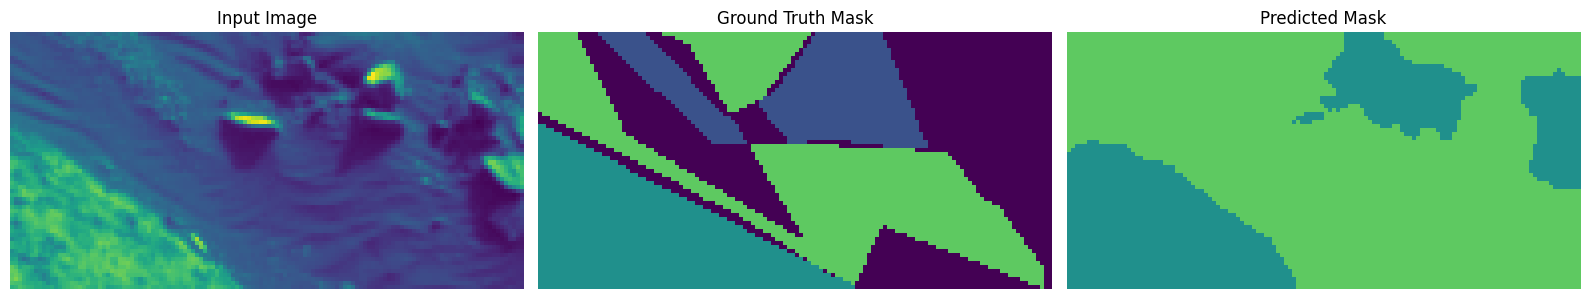

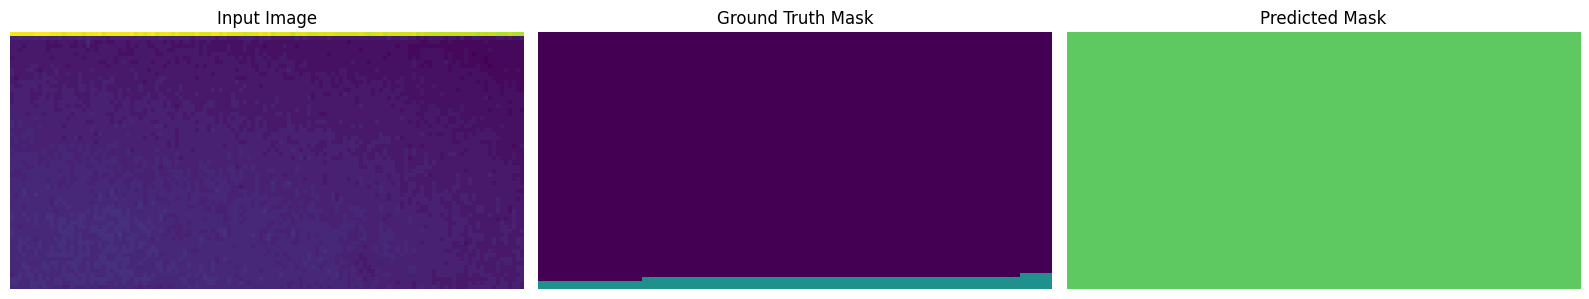

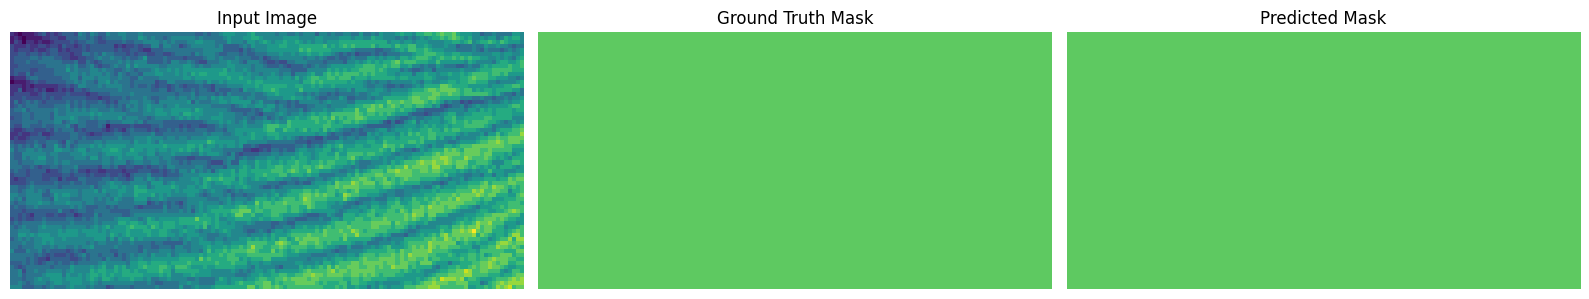

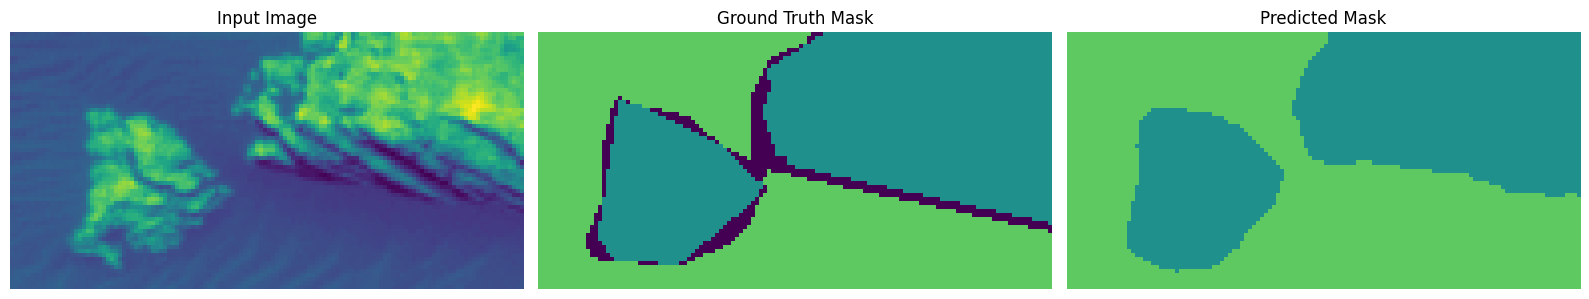

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 584ms/step - IoU_1: 0.9651 - IoU_2: 0.9441 - IoU_3: 0.9544 - IoU_4: 0.5937 - accuracy: 0.7355 - loss: 0.0135 - mean_io_u: 0.8668 - val_IoU_1: 0.9048 - val_IoU_2: 0.8071 - val_IoU_3: 0.8613 - val_IoU_4: 0.1681 - val_accuracy: 0.6989 - val_loss: 4.0454 - val_mean_io_u: 0.6853 - learning_rate: 1.6807e-04
Updated class weights: {0: 0, 1: 0.20237794859025507, 2: 0.2155013731363329, 3: 0.20801615237022672, 4: 0.37410452590318527}
Epoch 57/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 574ms/step - IoU_1: 0.9670 - IoU_2: 0.9479 - IoU_3: 0.9551 - IoU_4: 0.5956 - accuracy: 0.7348 - loss: 0.0121 - mean_io_u: 0.8729 - val_IoU_1: 0.8597 - val_IoU_2: 0.7358 - val_IoU_3: 0.8571 - val_IoU_4: 0.2849 - val_accuracy: 0.6811 - val_loss: 3.9375 - val_mean_io_u: 0.6844 - learning_rate: 1.6807e-04
Updated class weights: {0: 0, 1: 0.2140653752764941, 2: 0.2325276406729523, 3: 0.21442137877302256, 4: 0.33898560527753097}
Epoch 58/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - Io

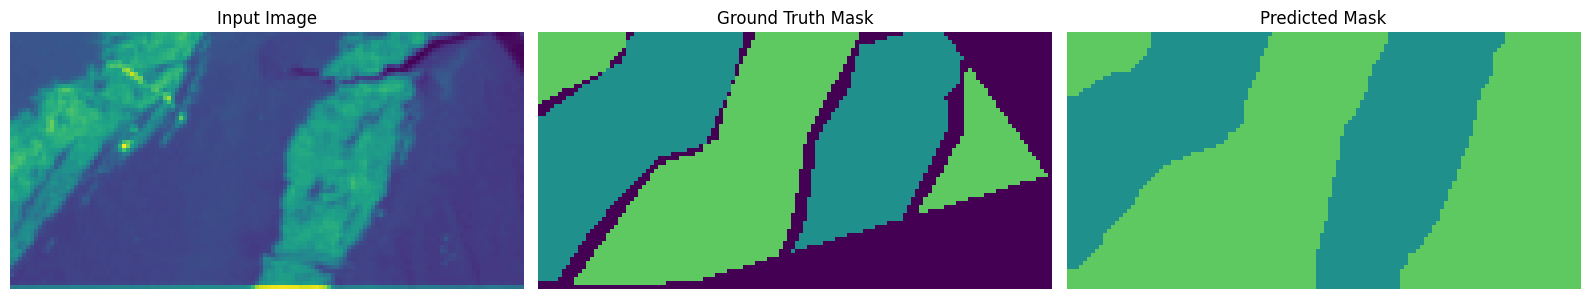

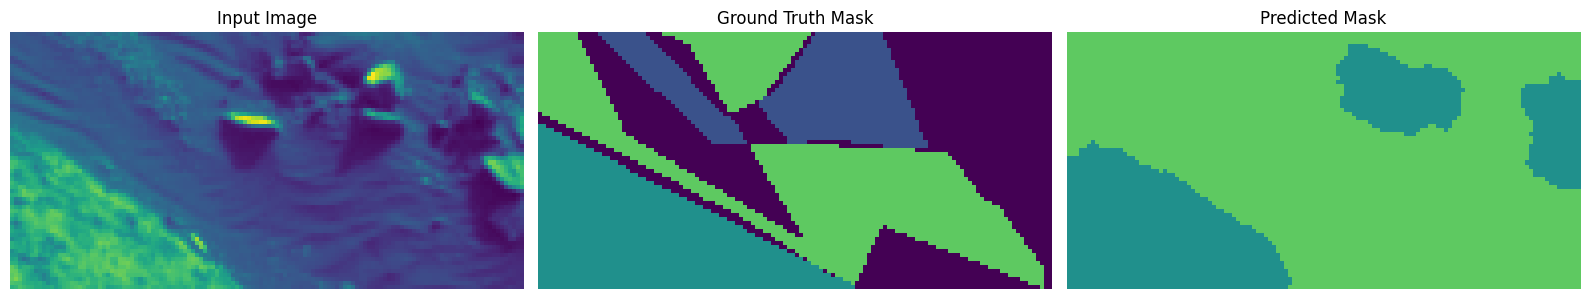

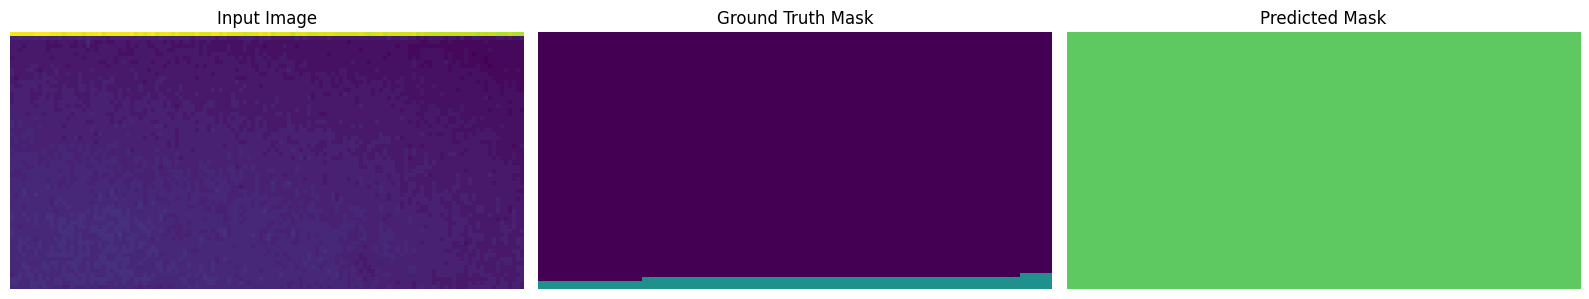

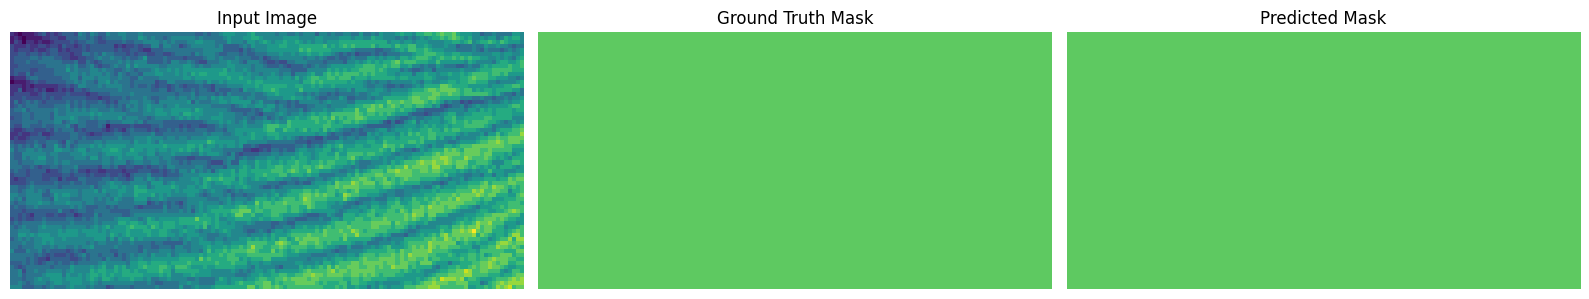

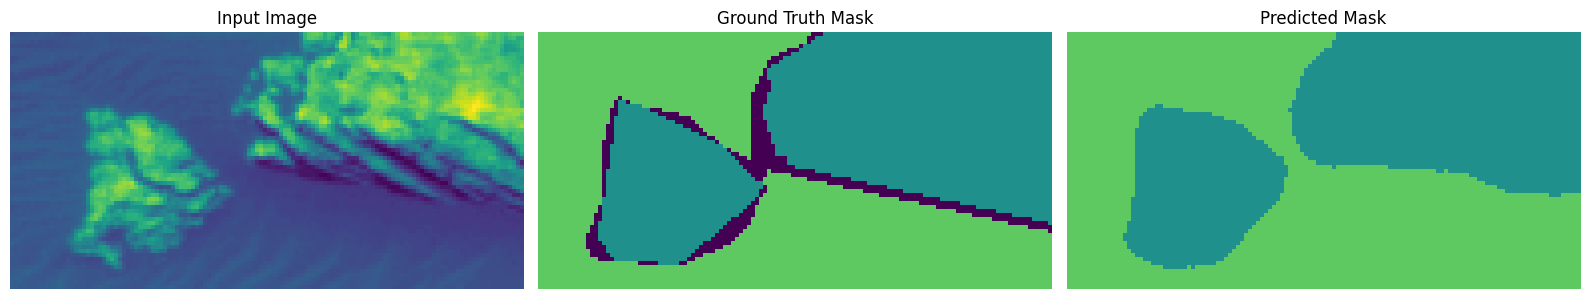

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 583ms/step - IoU_1: 0.9714 - IoU_2: 0.9526 - IoU_3: 0.9609 - IoU_4: 0.5879 - accuracy: 0.7385 - loss: 0.0110 - mean_io_u: 0.8682 - val_IoU_1: 0.8994 - val_IoU_2: 0.8078 - val_IoU_3: 0.8689 - val_IoU_4: 0.1228 - val_accuracy: 0.6990 - val_loss: 4.2465 - val_mean_io_u: 0.6747 - learning_rate: 1.6807e-04
Updated class weights: {0: 0, 1: 0.1990435614407149, 2: 0.21113258919279773, 3: 0.20291992362912162, 4: 0.3869039257373658}
Epoch 62/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9716 - IoU_2: 0.9541 - IoU_3: 0.9599 - IoU_4: 0.6419 - accuracy: 0.7377 - loss: 0.0109 - mean_io_u: 0.8857 - val_IoU_1: 0.8915 - val_IoU_2: 0.7973 - val_IoU_3: 0.8638 - val_IoU_4: 0.2140 - val_accuracy: 0.6958 - val_loss: 4.2380 - val_mean_io_u: 0.6916 - learning_rate: 1.6807e-04
Updated class weights: {0: 0, 1: 0.20738625979036127, 2: 0.22043408230112346, 3: 0.21105673524702295, 4: 0.3611229226614922}
Epoch 63/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - Io

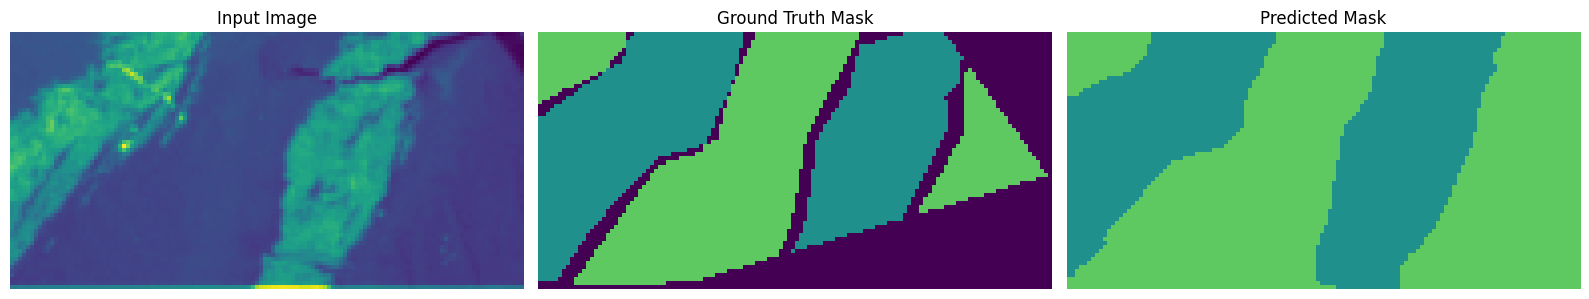

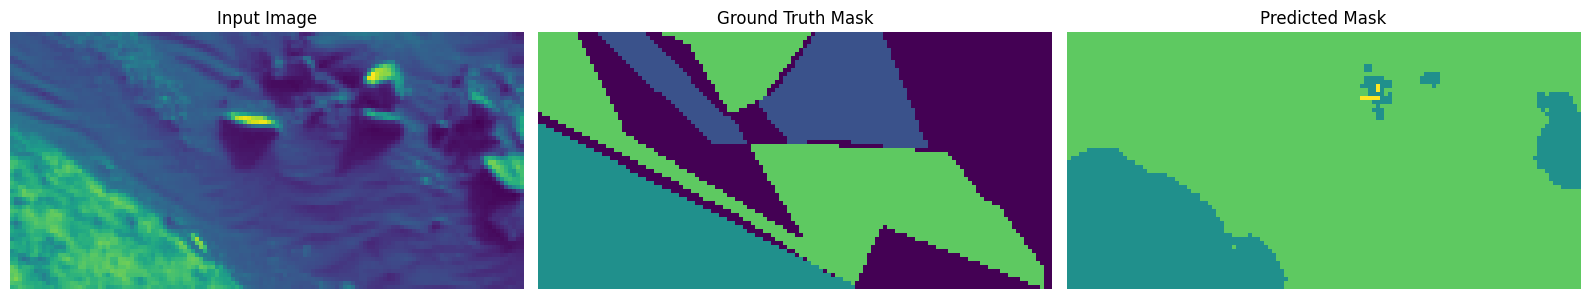

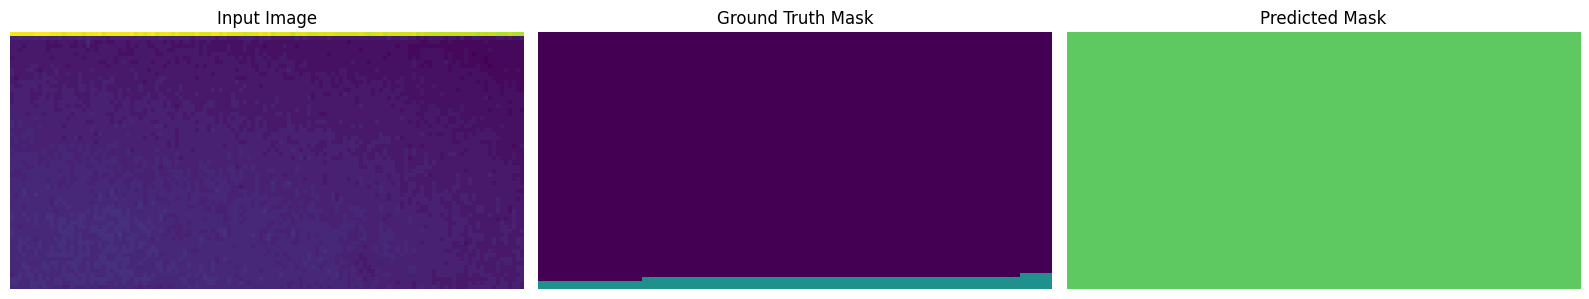

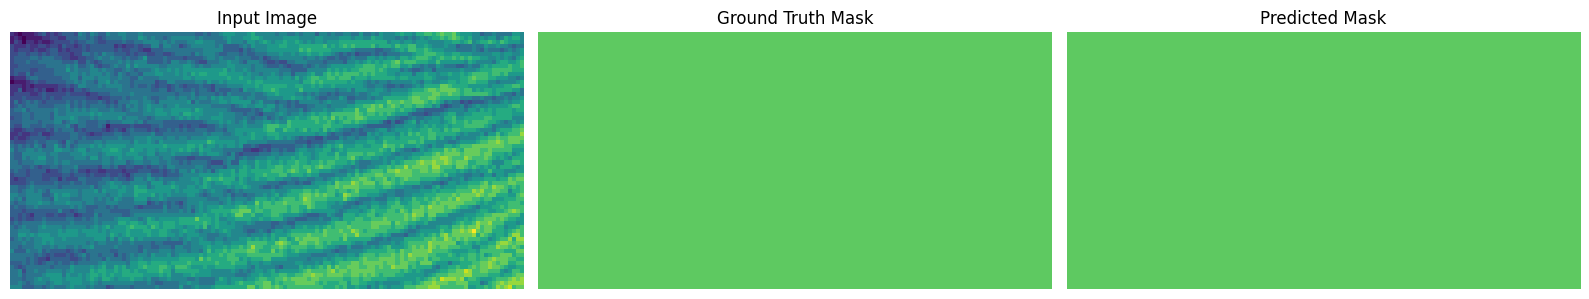

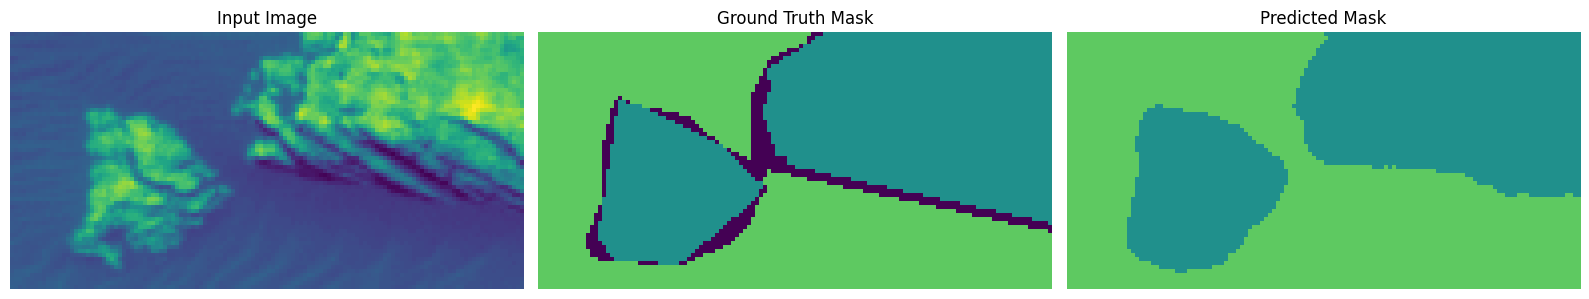

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 583ms/step - IoU_1: 0.9722 - IoU_2: 0.9541 - IoU_3: 0.9595 - IoU_4: 0.6198 - accuracy: 0.7397 - loss: 0.0108 - mean_io_u: 0.8764 - val_IoU_1: 0.8739 - val_IoU_2: 0.7647 - val_IoU_3: 0.8623 - val_IoU_4: 0.3182 - val_accuracy: 0.6884 - val_loss: 4.2608 - val_mean_io_u: 0.7048 - learning_rate: 1.1765e-04
Updated class weights: {0: 0, 1: 0.21608248551330755, 2: 0.23219354462324235, 3: 0.2176992428788019, 4: 0.33402472698464825}
Epoch 67/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9735 - IoU_2: 0.9540 - IoU_3: 0.9634 - IoU_4: 0.6548 - accuracy: 0.7394 - loss: 0.0103 - mean_io_u: 0.8877 - val_IoU_1: 0.8807 - val_IoU_2: 0.7822 - val_IoU_3: 0.8589 - val_IoU_4: 0.3097 - val_accuracy: 0.6908 - val_loss: 4.2287 - val_mean_io_u: 0.7079 - learning_rate: 1.1765e-04
Updated class weights: {0: 0, 1: 0.21524311373825514, 2: 0.22953553925087888, 3: 0.21825326363862535, 4: 0.33696808337224055}
Epoch 68/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - 

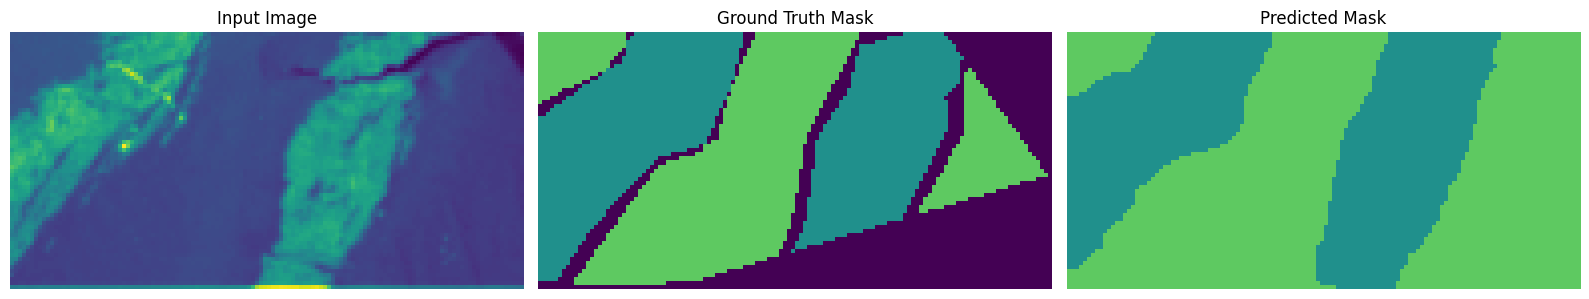

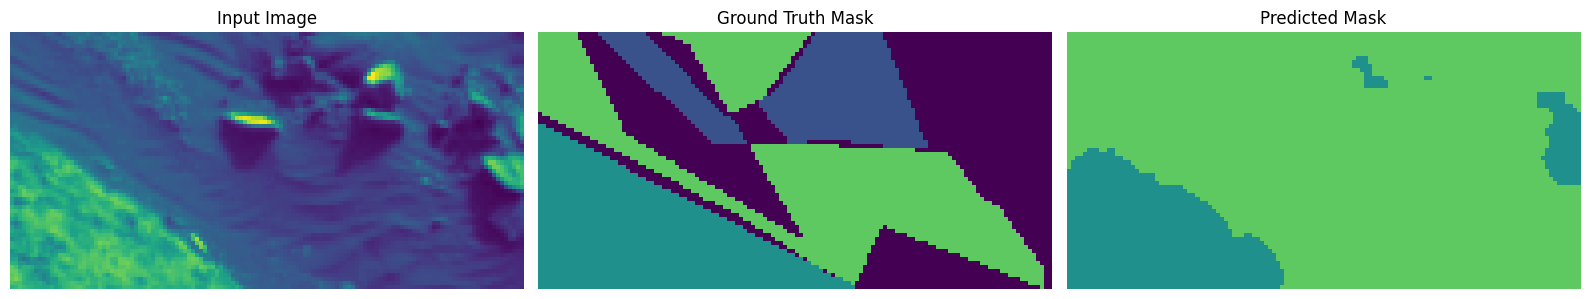

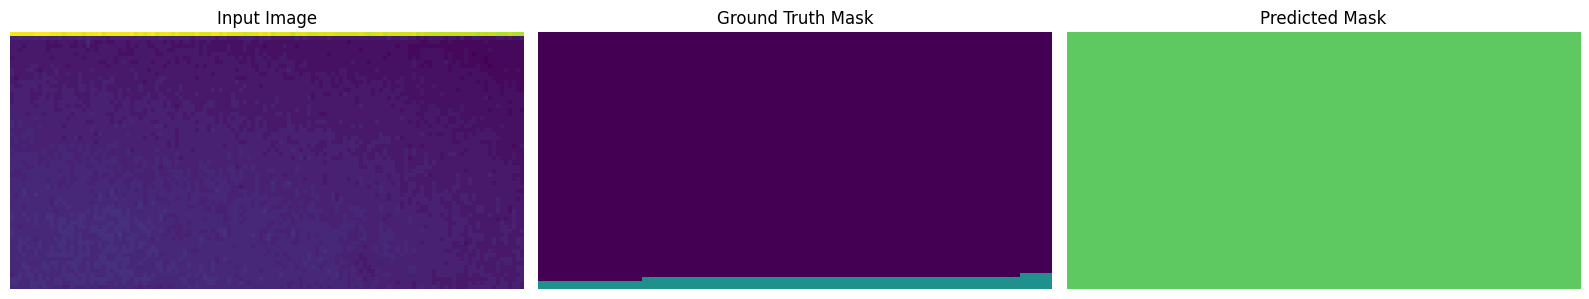

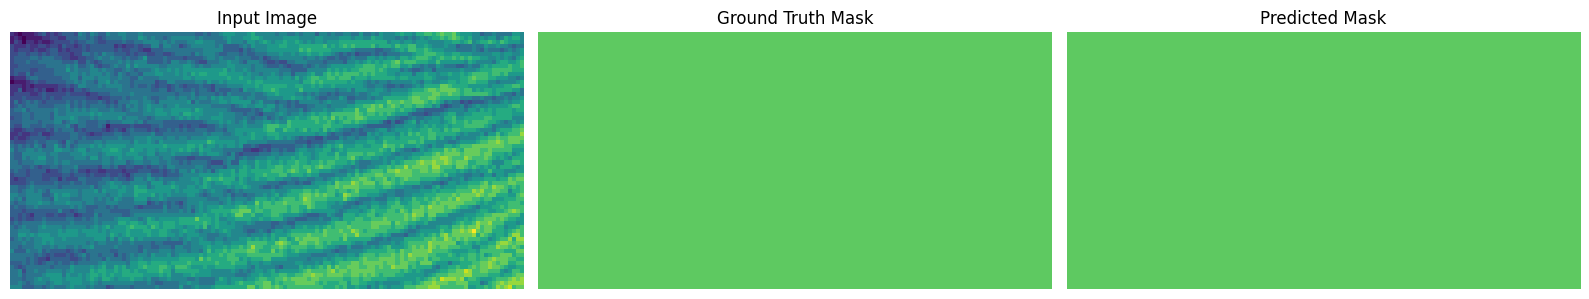

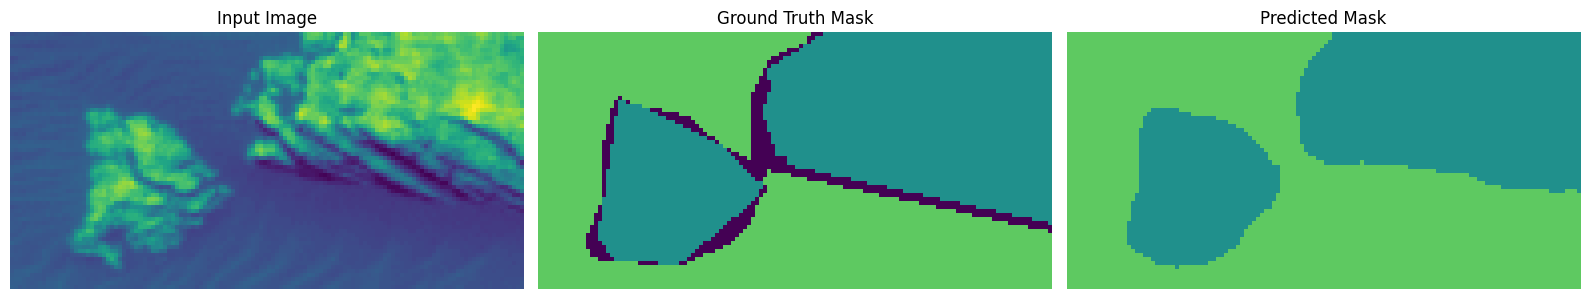

188/188 ━━━━━━━━━━━━━━━━━━━━ 109s 583ms/step - IoU_1: 0.9721 - IoU_2: 0.9543 - IoU_3: 0.9573 - IoU_4: 0.6757 - accuracy: 0.7374 - loss: 0.0106 - mean_io_u: 0.8899 - val_IoU_1: 0.8964 - val_IoU_2: 0.8034 - val_IoU_3: 0.8570 - val_IoU_4: 0.2183 - val_accuracy: 0.6967 - val_loss: 4.2701 - val_mean_io_u: 0.6938 - learning_rate: 1.1765e-04
Updated class weights: {0: 0, 1: 0.20722535522287647, 2: 0.22004712344822536, 3: 0.2124627127854832, 4: 0.36026480854341497}
Epoch 72/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - IoU_1: 0.9736 - IoU_2: 0.9570 - IoU_3: 0.9661 - IoU_4: 0.6694 - accuracy: 0.7392 - loss: 0.0100 - mean_io_u: 0.8954 - val_IoU_1: 0.8782 - val_IoU_2: 0.7639 - val_IoU_3: 0.8602 - val_IoU_4: 0.3610 - val_accuracy: 0.6888 - val_loss: 4.3943 - val_mean_io_u: 0.7158 - learning_rate: 1.1765e-04
Updated class weights: {0: 0, 1: 0.21847834442592276, 2: 0.23553275314179706, 3: 0.2209984580325784, 4: 0.3249904443997017}
Epoch 73/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - Io

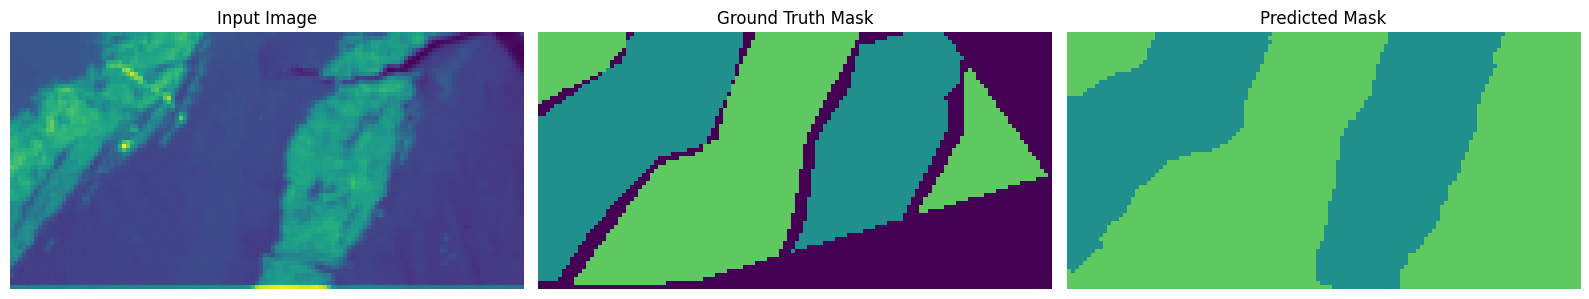

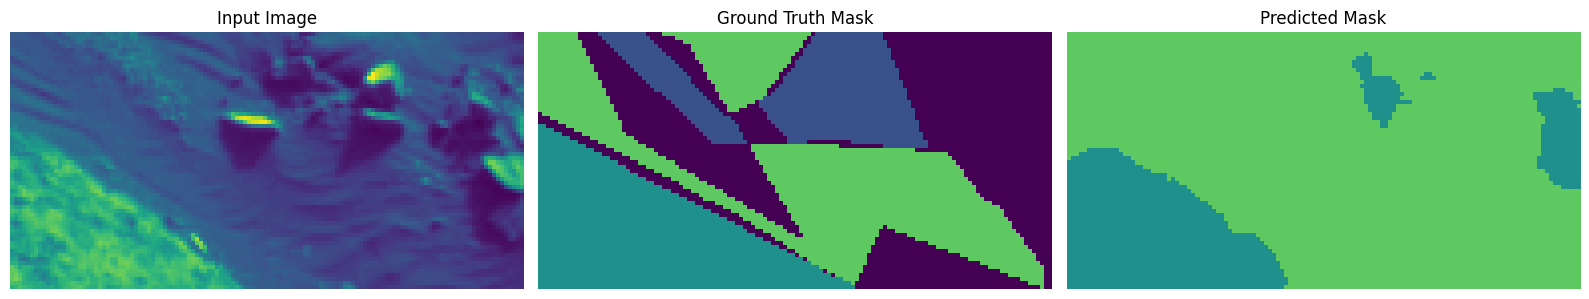

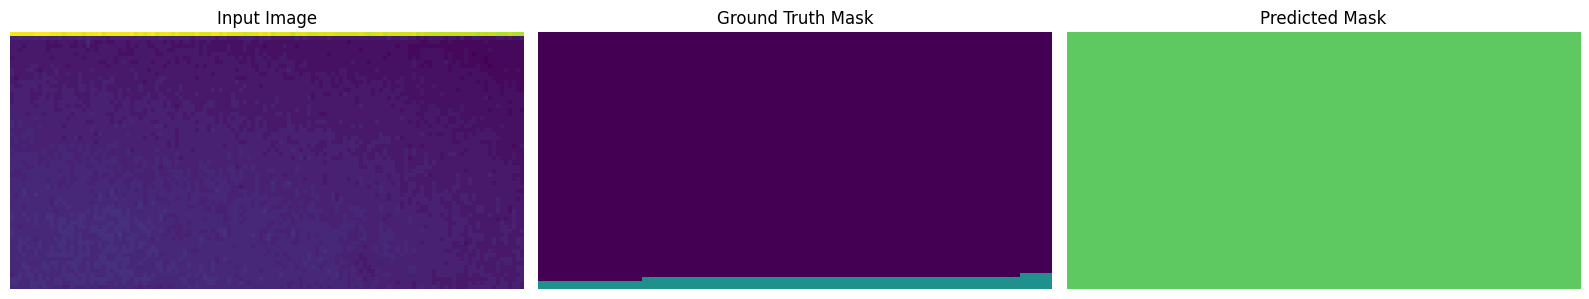

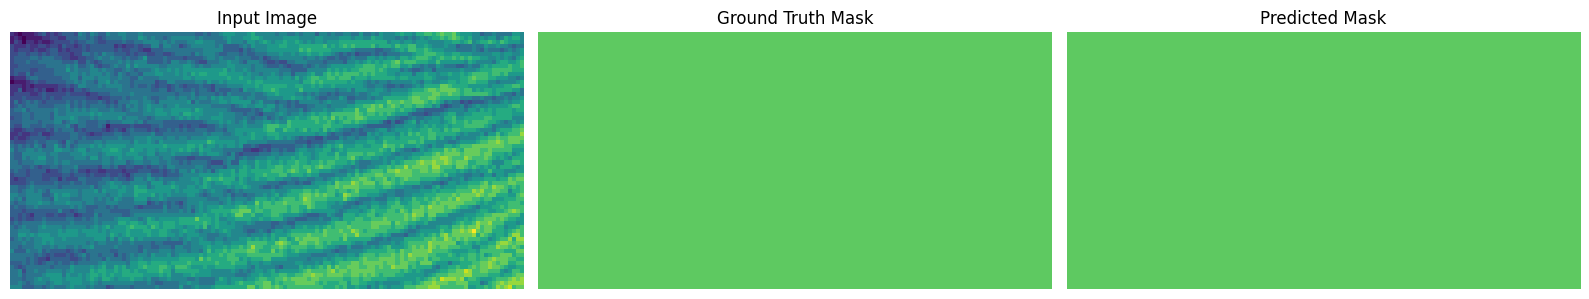

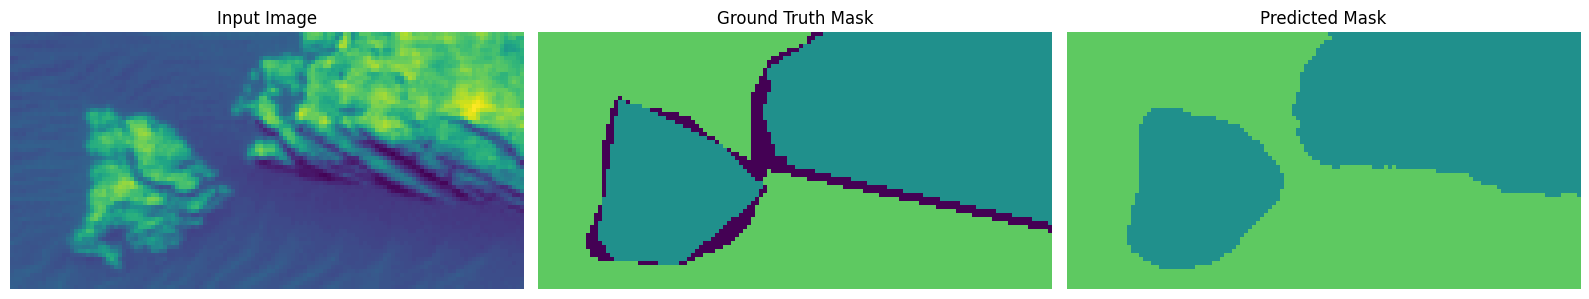

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 585ms/step - IoU_1: 0.9742 - IoU_2: 0.9577 - IoU_3: 0.9657 - IoU_4: 0.6746 - accuracy: 0.7397 - loss: 0.0096 - mean_io_u: 0.8931 - val_IoU_1: 0.8917 - val_IoU_2: 0.7926 - val_IoU_3: 0.8558 - val_IoU_4: 0.3320 - val_accuracy: 0.6945 - val_loss: 4.4156 - val_mean_io_u: 0.7180 - learning_rate: 8.2354e-05
Updated class weights: {0: 0, 1: 0.21589354280919523, 2: 0.23023677618532296, 3: 0.22087475010847016, 4: 0.33299493089701165}
Epoch 77/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9766 - IoU_2: 0.9624 - IoU_3: 0.9659 - IoU_4: 0.7095 - accuracy: 0.7401 - loss: 0.0087 - mean_io_u: 0.9049 - val_IoU_1: 0.8880 - val_IoU_2: 0.7919 - val_IoU_3: 0.8637 - val_IoU_4: 0.3175 - val_accuracy: 0.6944 - val_loss: 4.4768 - val_mean_io_u: 0.7153 - learning_rate: 8.2354e-05
Updated class weights: {0: 0, 1: 0.21549148105408564, 2: 0.22936749035710083, 3: 0.2188353528475345, 4: 0.33630567574127906}
Epoch 78/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - 

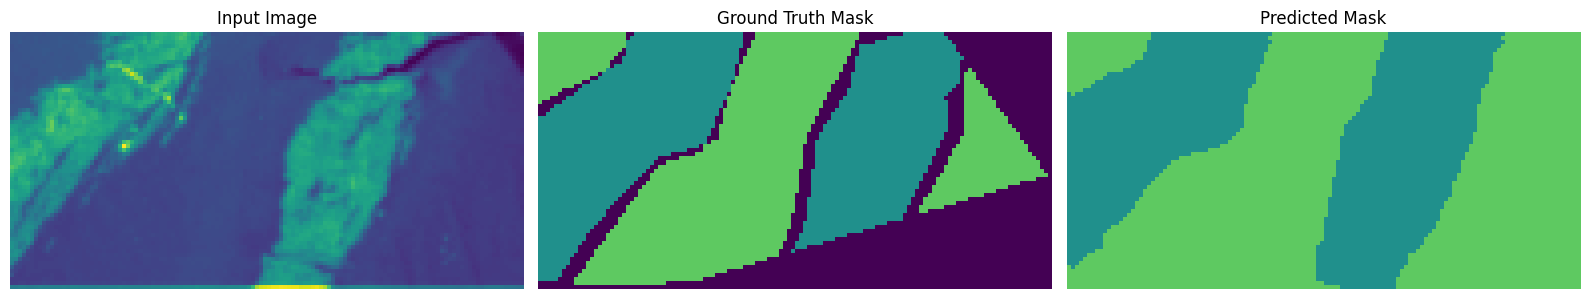

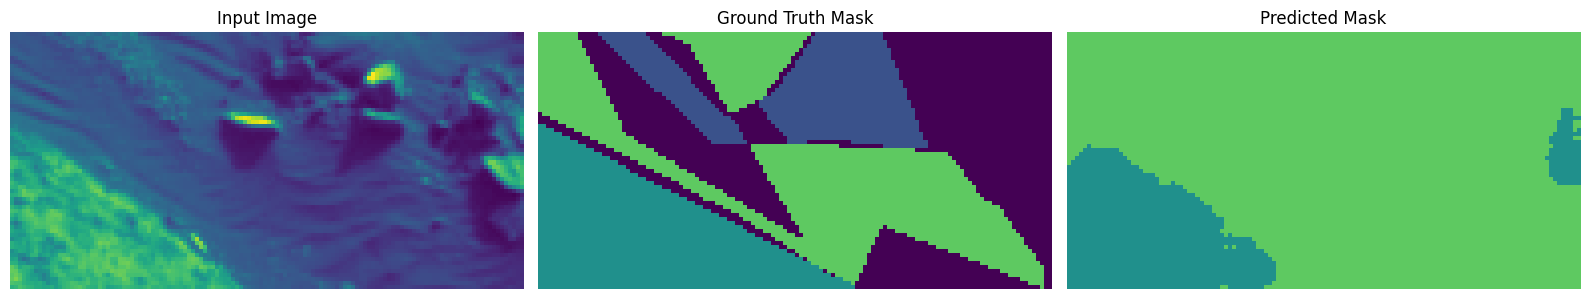

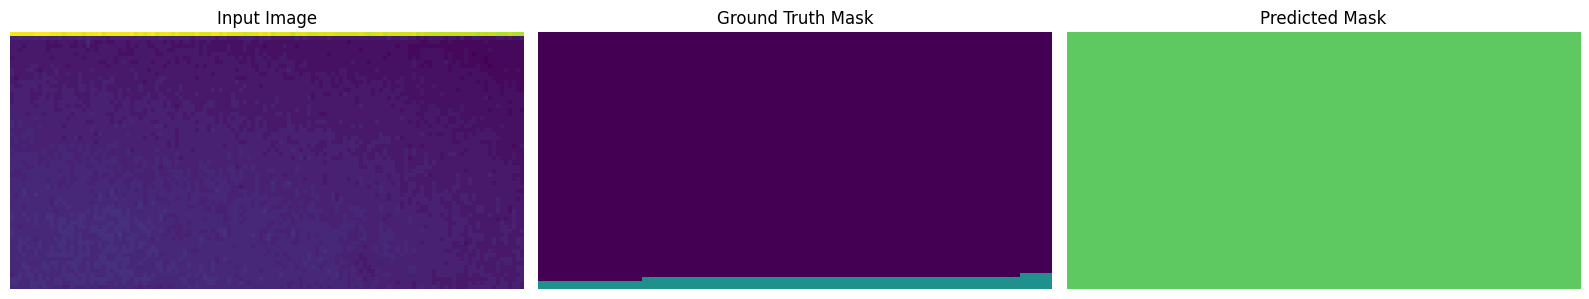

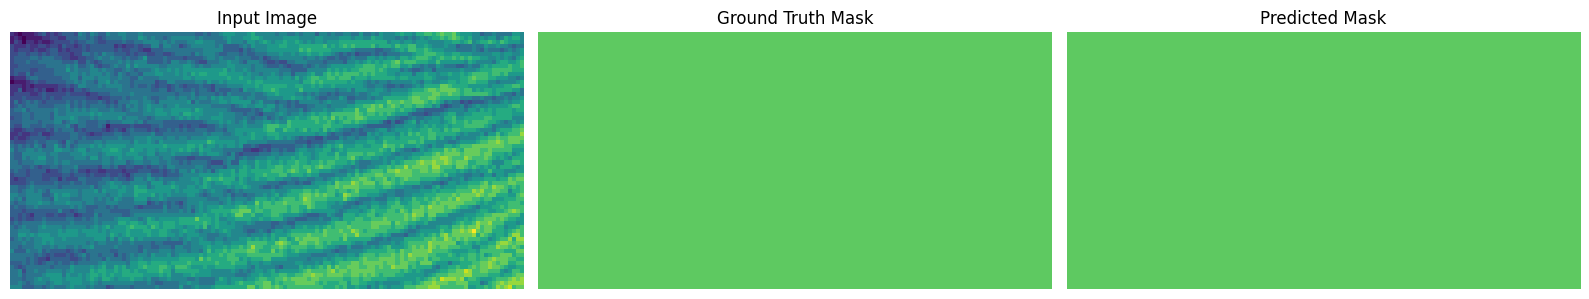

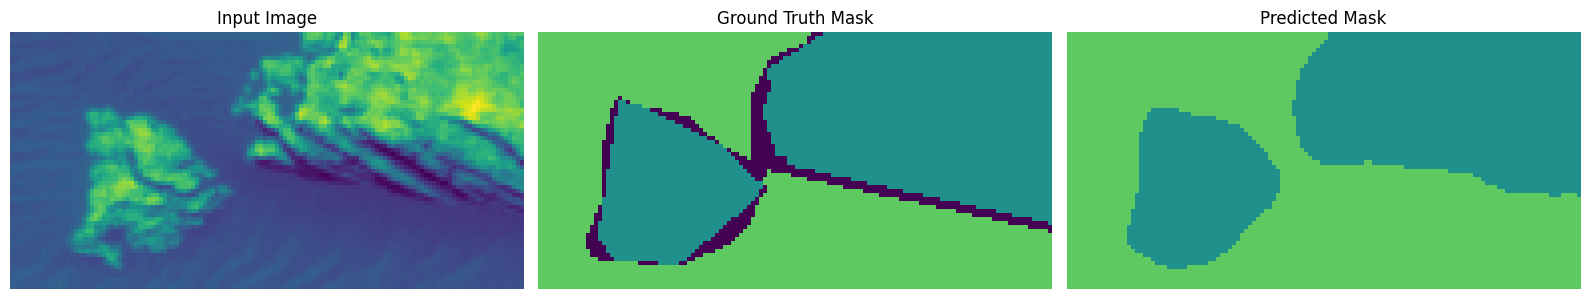

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 584ms/step - IoU_1: 0.9788 - IoU_2: 0.9655 - IoU_3: 0.9696 - IoU_4: 0.6906 - accuracy: 0.7417 - loss: 0.0081 - mean_io_u: 0.9011 - val_IoU_1: 0.8889 - val_IoU_2: 0.7961 - val_IoU_3: 0.8618 - val_IoU_4: 0.2760 - val_accuracy: 0.6950 - val_loss: 4.5808 - val_mean_io_u: 0.7057 - learning_rate: 8.2354e-05
Updated class weights: {0: 0, 1: 0.21242718564685573, 2: 0.22560469762874152, 3: 0.21612460986125245, 4: 0.34584350686315035}
Epoch 82/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - IoU_1: 0.9778 - IoU_2: 0.9643 - IoU_3: 0.9666 - IoU_4: 0.7141 - accuracy: 0.7420 - loss: 0.0083 - mean_io_u: 0.9096 - val_IoU_1: 0.8981 - val_IoU_2: 0.8111 - val_IoU_3: 0.8683 - val_IoU_4: 0.1924 - val_accuracy: 0.6990 - val_loss: 4.5906 - val_mean_io_u: 0.6924 - learning_rate: 8.2354e-05
Updated class weights: {0: 0, 1: 0.20544963925804602, 2: 0.2172784167524777, 3: 0.2093490668735626, 4: 0.36792287711591365}
Epoch 83/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - I

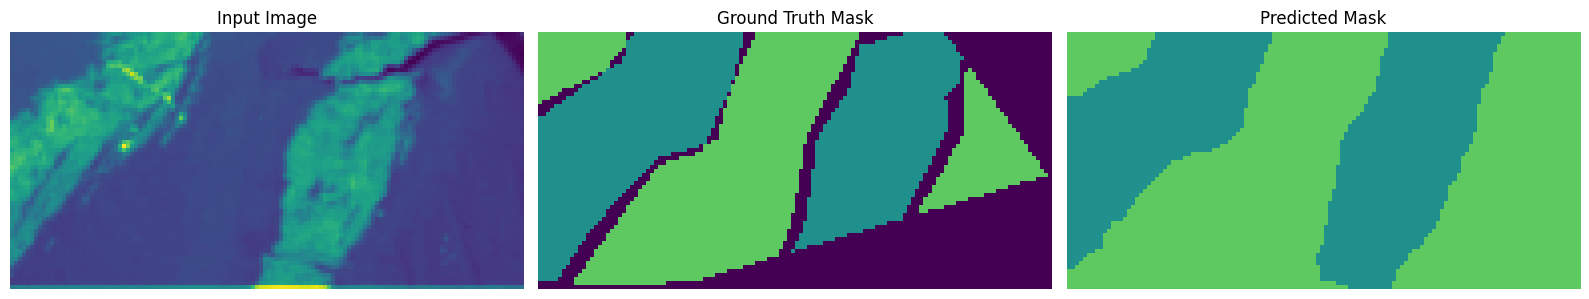

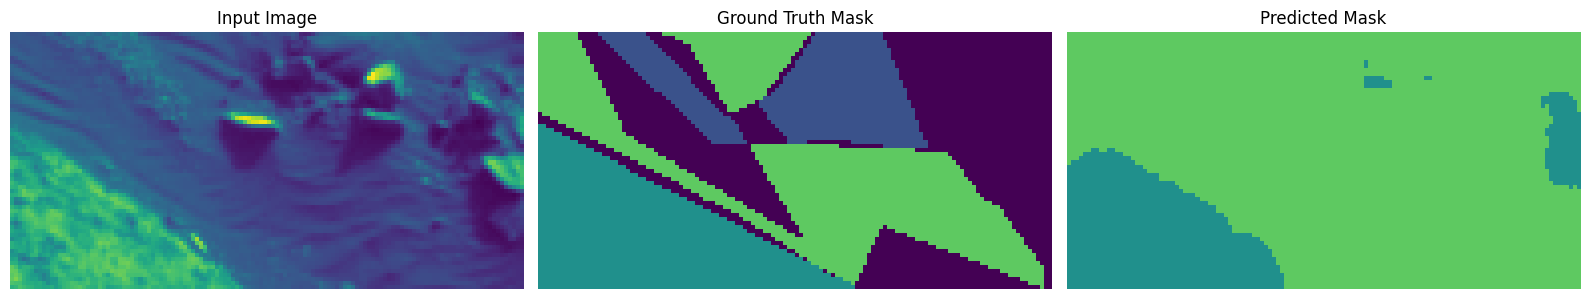

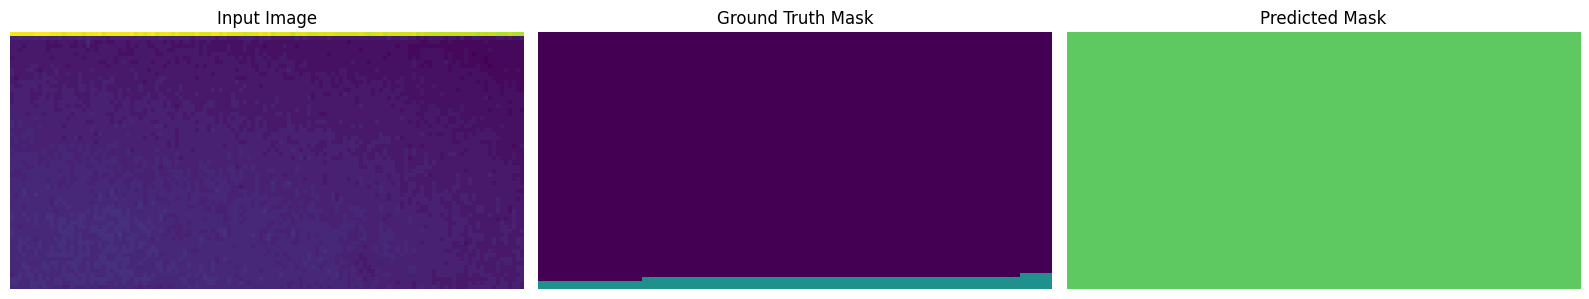

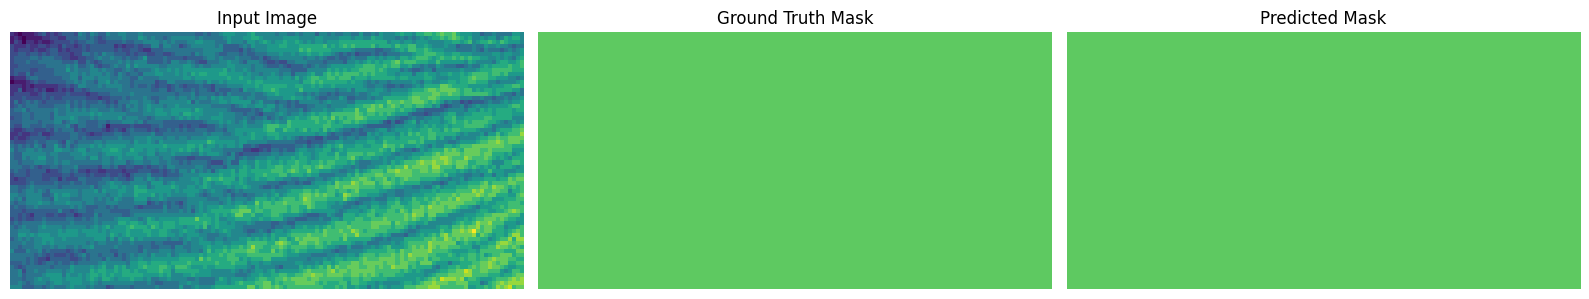

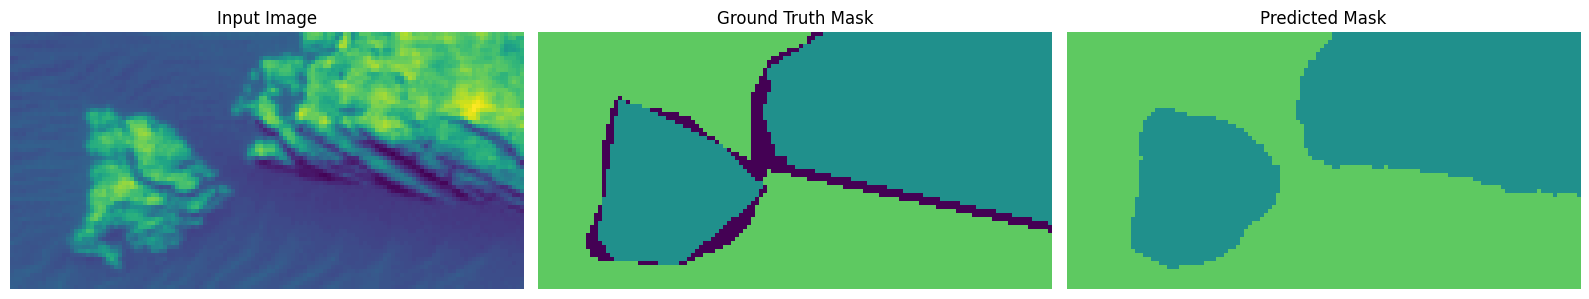

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 585ms/step - IoU_1: 0.9771 - IoU_2: 0.9650 - IoU_3: 0.9677 - IoU_4: 0.7478 - accuracy: 0.7410 - loss: 0.0082 - mean_io_u: 0.9196 - val_IoU_1: 0.8855 - val_IoU_2: 0.7978 - val_IoU_3: 0.8596 - val_IoU_4: 0.1740 - val_accuracy: 0.6941 - val_loss: 4.5845 - val_mean_io_u: 0.6792 - learning_rate: 5.7648e-05
Updated class weights: {0: 0, 1: 0.20453160920668478, 2: 0.21651101936777228, 3: 0.20793175243115003, 4: 0.37102561899439296}
Epoch 87/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9791 - IoU_2: 0.9647 - IoU_3: 0.9730 - IoU_4: 0.7398 - accuracy: 0.7421 - loss: 0.0081 - mean_io_u: 0.9181 - val_IoU_1: 0.8900 - val_IoU_2: 0.7989 - val_IoU_3: 0.8572 - val_IoU_4: 0.3529 - val_accuracy: 0.6950 - val_loss: 4.5750 - val_mean_io_u: 0.7248 - learning_rate: 5.7648e-05
Updated class weights: {0: 0, 1: 0.21777225250825635, 2: 0.23100766309852078, 3: 0.22236187304164673, 4: 0.3288582113515761}
Epoch 88/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 574ms/step - 

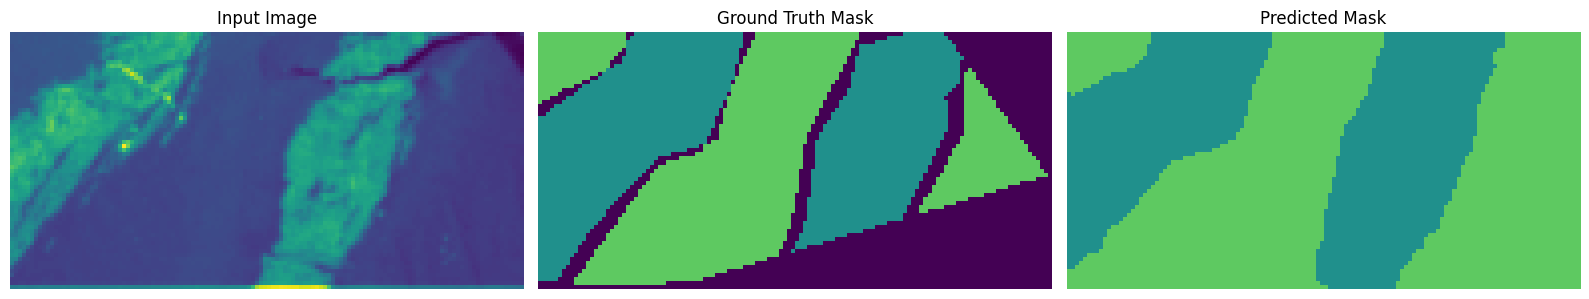

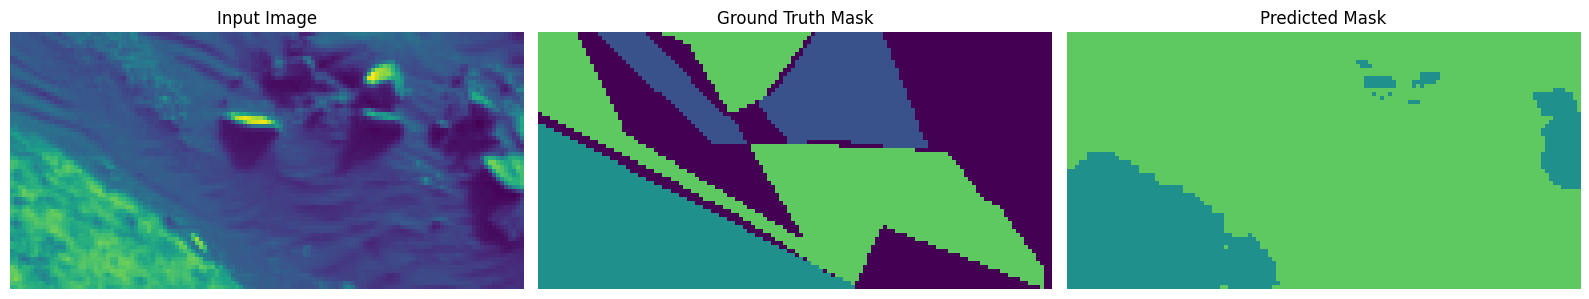

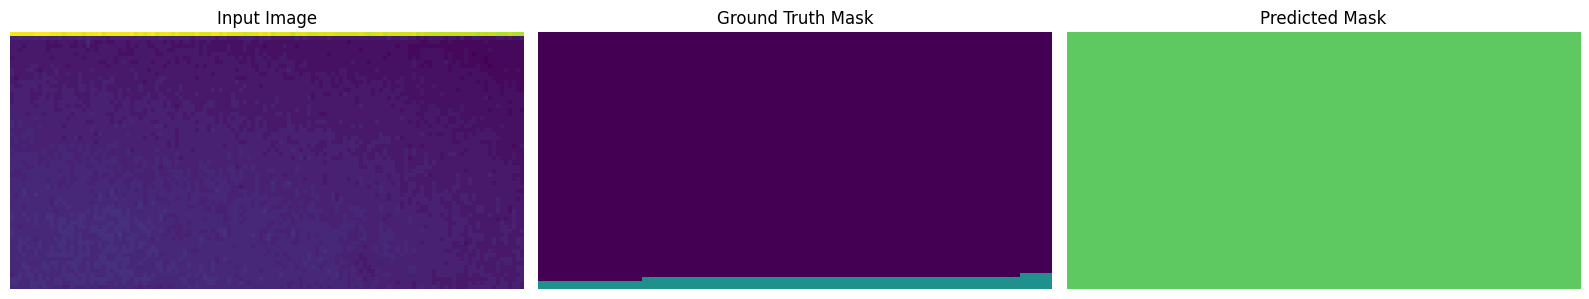

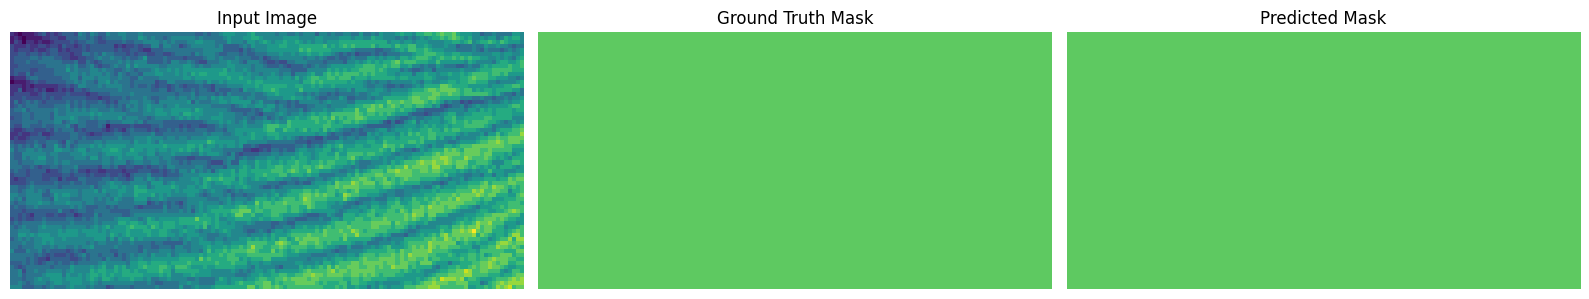

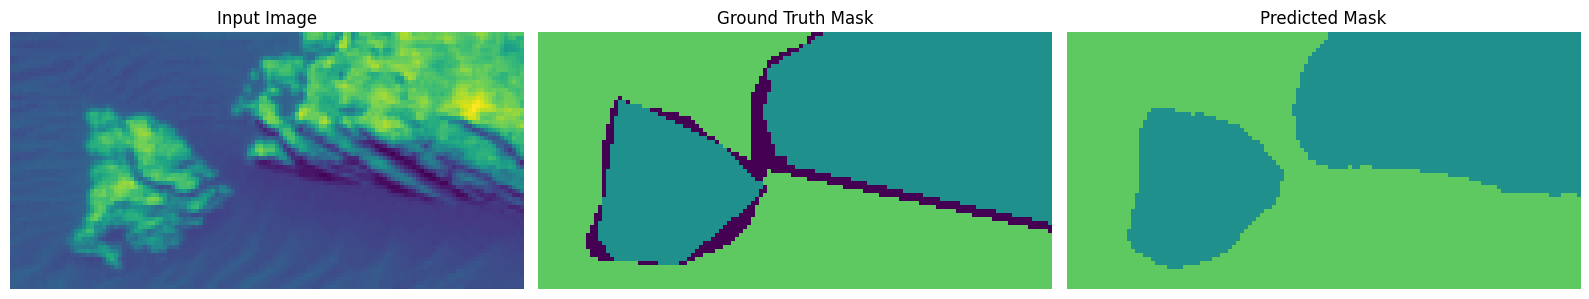

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 584ms/step - IoU_1: 0.9800 - IoU_2: 0.9668 - IoU_3: 0.9697 - IoU_4: 0.7299 - accuracy: 0.7425 - loss: 0.0080 - mean_io_u: 0.9155 - val_IoU_1: 0.8886 - val_IoU_2: 0.7920 - val_IoU_3: 0.8541 - val_IoU_4: 0.2366 - val_accuracy: 0.6934 - val_loss: 4.5925 - val_mean_io_u: 0.6928 - learning_rate: 5.7648e-05
Updated class weights: {0: 0, 1: 0.20906663714853313, 2: 0.2226059866808797, 3: 0.21370748599727224, 4: 0.3546198901733149}
Epoch 92/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 575ms/step - IoU_1: 0.9791 - IoU_2: 0.9653 - IoU_3: 0.9681 - IoU_4: 0.7342 - accuracy: 0.7411 - loss: 0.0077 - mean_io_u: 0.9143 - val_IoU_1: 0.8879 - val_IoU_2: 0.7856 - val_IoU_3: 0.8583 - val_IoU_4: 0.2006 - val_accuracy: 0.6930 - val_loss: 4.7731 - val_mean_io_u: 0.6831 - learning_rate: 5.7648e-05
Updated class weights: {0: 0, 1: 0.20613718779394696, 2: 0.22033401680704767, 3: 0.21006295219130125, 4: 0.36346584320770414}
Epoch 93/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 577ms/step - I

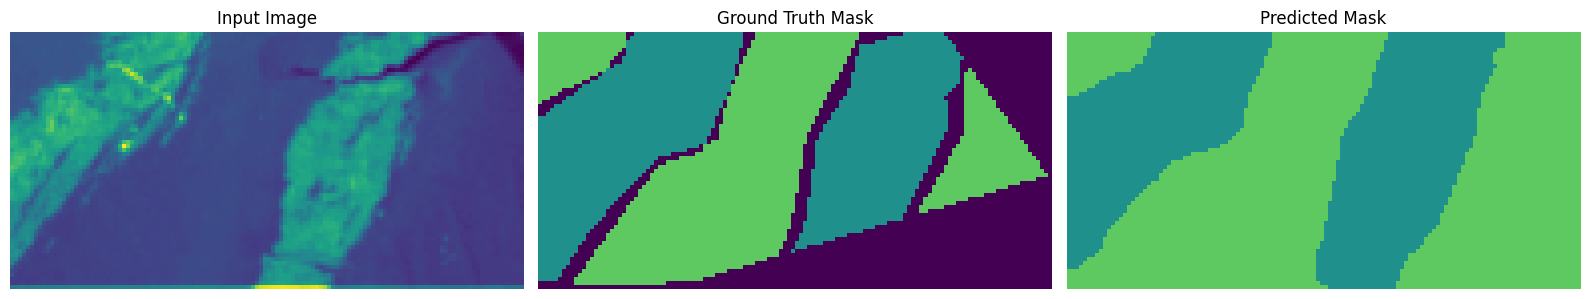

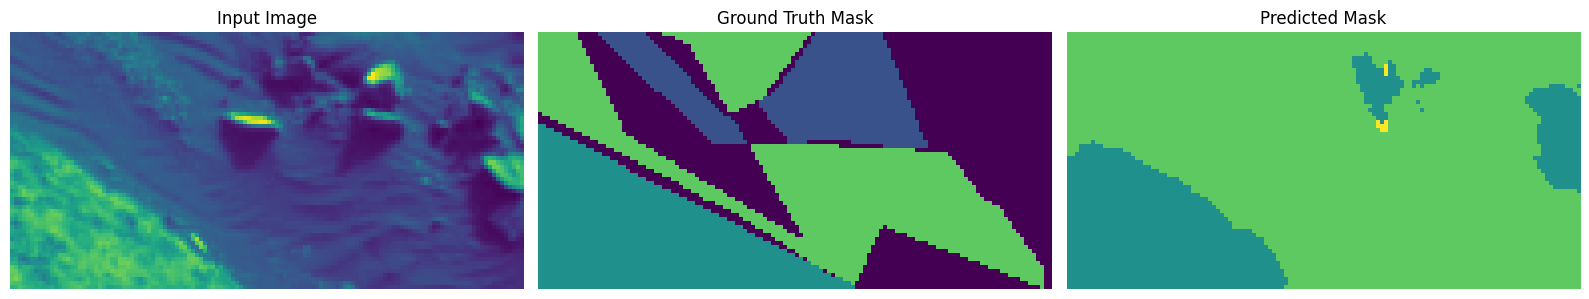

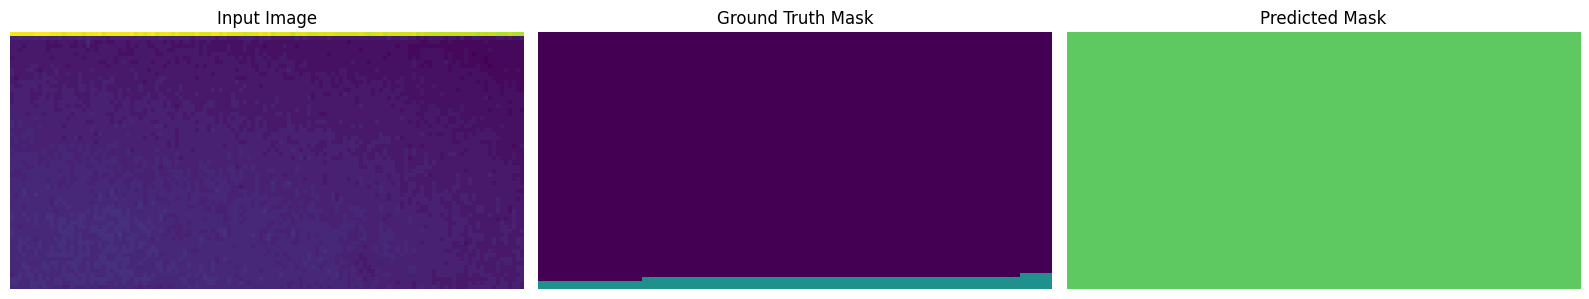

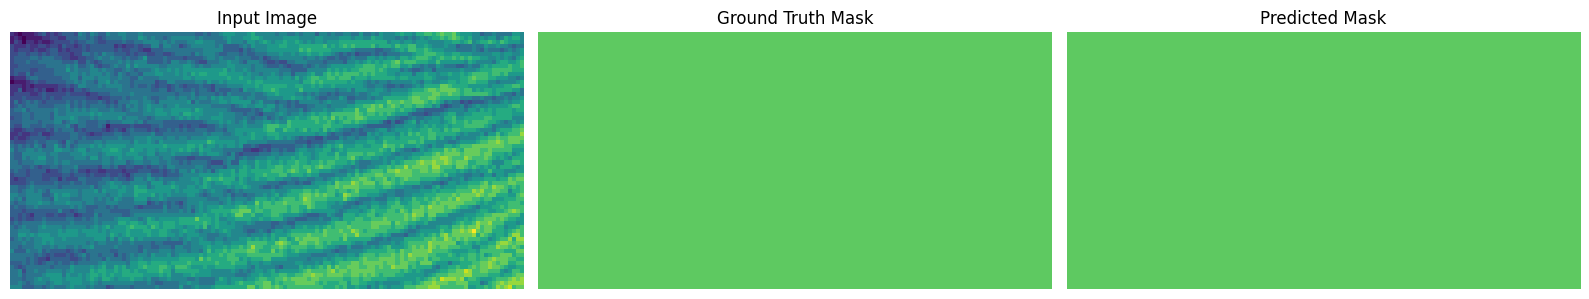

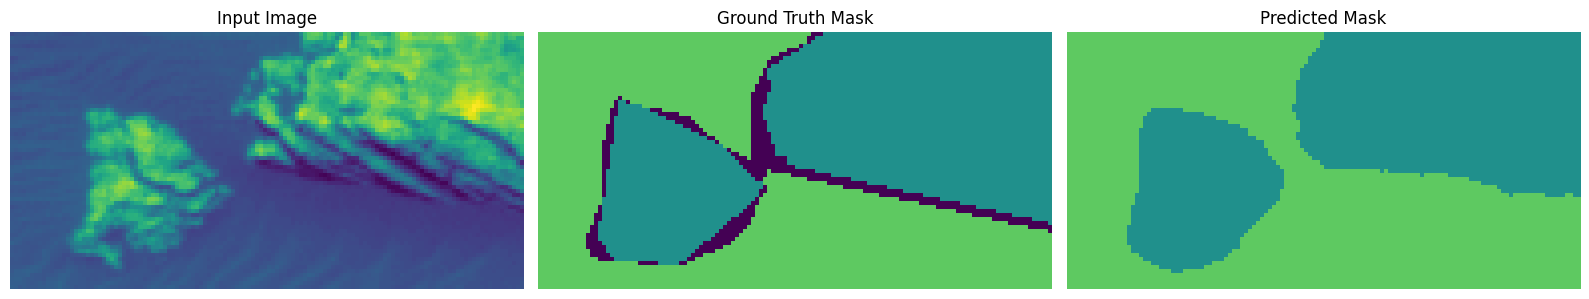

188/188 ━━━━━━━━━━━━━━━━━━━━ 110s 585ms/step - IoU_1: 0.9790 - IoU_2: 0.9657 - IoU_3: 0.9686 - IoU_4: 0.7341 - accuracy: 0.7408 - loss: 0.0080 - mean_io_u: 0.9158 - val_IoU_1: 0.8900 - val_IoU_2: 0.7970 - val_IoU_3: 0.8567 - val_IoU_4: 0.2943 - val_accuracy: 0.6945 - val_loss: 4.8385 - val_mean_io_u: 0.7095 - learning_rate: 4.0354e-05
Updated class weights: {0: 0, 1: 0.21355627003769997, 2: 0.2268196977454955, 3: 0.21811935643453506, 4: 0.34150467578226934}
Epoch 97/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 577ms/step - IoU_1: 0.9807 - IoU_2: 0.9681 - IoU_3: 0.9725 - IoU_4: 0.7467 - accuracy: 0.7433 - loss: 0.0074 - mean_io_u: 0.9209 - val_IoU_1: 0.8754 - val_IoU_2: 0.7733 - val_IoU_3: 0.8600 - val_IoU_4: 0.3126 - val_accuracy: 0.6892 - val_loss: 4.7439 - val_mean_io_u: 0.7053 - learning_rate: 4.0354e-05
Updated class weights: {0: 0, 1: 0.21575248323559815, 2: 0.23069271896444526, 3: 0.21788094887414336, 4: 0.33567384892581326}
Epoch 98/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 108s 576ms/step - 

In [24]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, reduce_lr, weights, model_checkpoint],
   # verbose=1,
    class_weight=class_weight
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

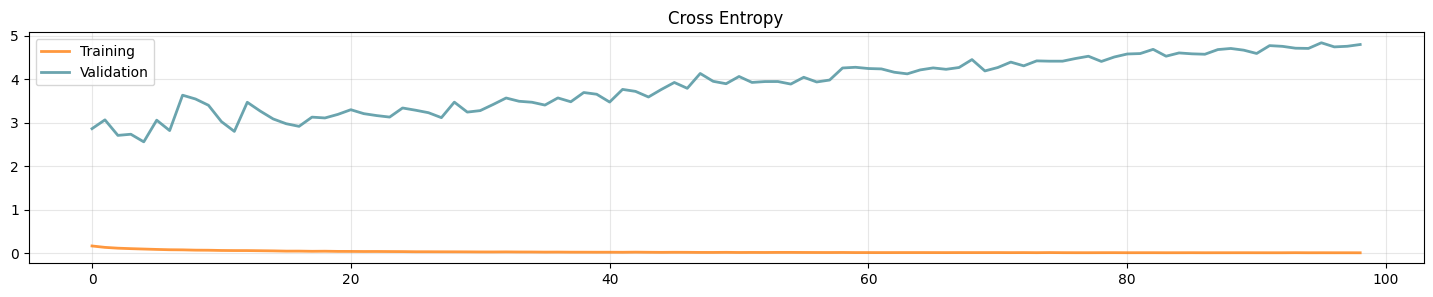

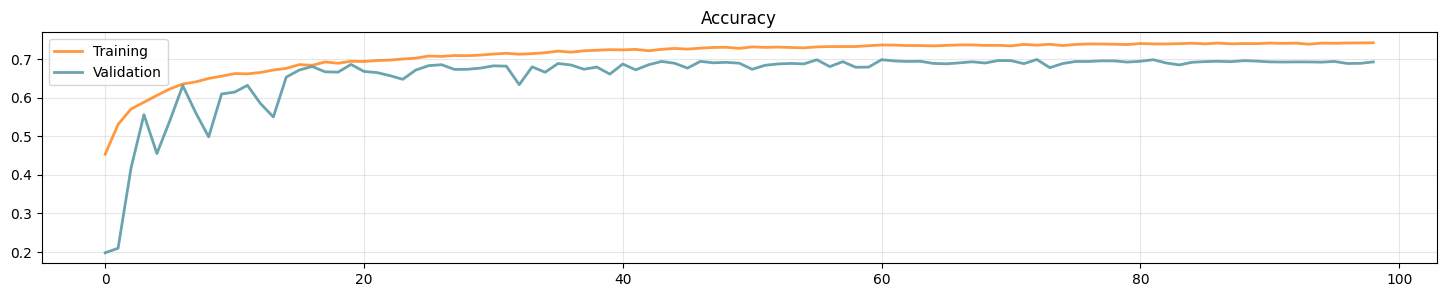

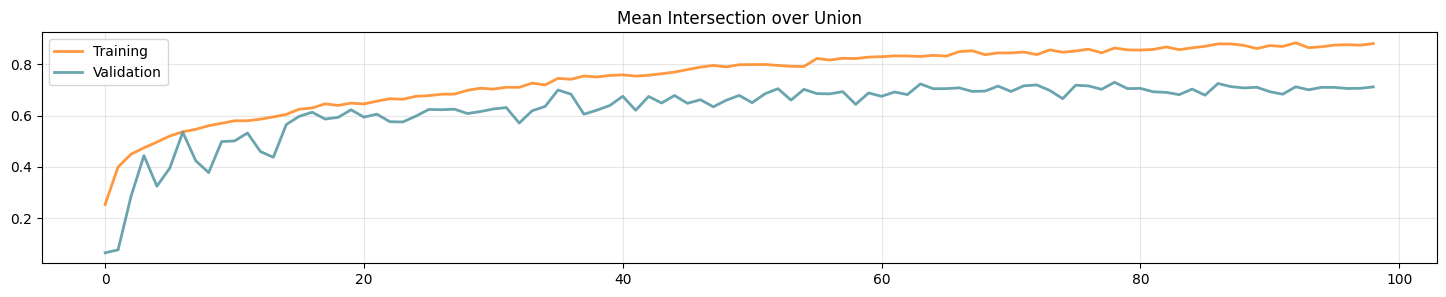

In [27]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [28]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_241214_205657.keras


In [29]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [30]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_205657.keras


In [42]:
# Function to apply Albumentations transformations
def aug_fn_1(image):
    # Convert TensorFlow tensors to NumPy
    image = image.numpy()
    # Apply the Albumentations transformation
    augmented = horizontal_flip(image=image)
    aug_image = augmented["image"]

    return aug_image

# Wrapper to apply augmentation within TensorFlow pipelines
def tf_augment_1(image):
    # Use tf.py_function to apply aug_fn
    aug_image = tf.py_function(
        func=aug_fn_1, inp=[image], Tout=tf.float32
    )
    # Set shapes explicitly because tf.py_function loses shape information
    aug_image.set_shape(image.shape)

    return aug_image

def aug_fn_2(image):
    # Convert TensorFlow tensors to NumPy
    image = image.numpy()
    # Apply the Albumentations transformation
    augmented = vertical_flip(image=image)
    aug_image = augmented["image"]

    return aug_image

# Wrapper to apply augmentation within TensorFlow pipelines
def tf_augment_2(image):
    # Use tf.py_function to apply aug_fn
    aug_image = tf.py_function(
        func=aug_fn_2, inp=[image], Tout=tf.float32
    )
    # Set shapes explicitly because tf.py_function loses shape information
    aug_image.set_shape(image.shape)

    return aug_image

def aug_fn_3(image):
    # Convert TensorFlow tensors to NumPy
    image = image.numpy()
    # Apply the Albumentations transformation
    augmented = rotate(image=image)
    aug_image = augmented["image"]

    return aug_image

# Wrapper to apply augmentation within TensorFlow pipelines
def tf_augment_3(image):
    # Use tf.py_function to apply aug_fn
    aug_image = tf.py_function(
        func=aug_fn_3, inp=[image], Tout=tf.float32
    )
    # Set shapes explicitly because tf.py_function loses shape information
    aug_image.set_shape(image.shape)

    return aug_image

def aug_fn_4(image):
    # Convert TensorFlow tensors to NumPy
    image = image.numpy()
    # Apply the Albumentations transformation
    augmented = brightness(image=image)
    aug_image = augmented["image"]

    return aug_image

# Wrapper to apply augmentation within TensorFlow pipelines
def tf_augment_4(image):
    # Use tf.py_function to apply aug_fn
    aug_image = tf.py_function(
        func=aug_fn_4, inp=[image], Tout=tf.float32
    )
    # Set shapes explicitly because tf.py_function loses shape information
    aug_image.set_shape(image.shape)

    return aug_image

def horizontal_flip(image):
    aug = A.HorizontalFlip(p=1)
    image = aug(image=image)
    return image

def vertical_flip(image):
    aug = A.VerticalFlip(p=1)
    image = aug(image=image)
    return image

def rotate(image):
    aug = A.Rotate(limit=(180, 180), p=1)
    image = aug(image=image)
    return image

def brightness(image):
    aug = A.RandomBrightnessContrast(p=1)
    image = aug(image=image)
    return image
    
dataset_1 = tf.data.Dataset.from_tensor_slices((X_test))
dataset_2 = tf.data.Dataset.from_tensor_slices((X_test))
dataset_3 = tf.data.Dataset.from_tensor_slices((X_test))
dataset_4 = tf.data.Dataset.from_tensor_slices((X_test))

dataset_1 = dataset_1.map(lambda x: tf_augment_1(x), num_parallel_calls=tf.data.AUTOTUNE)
dataset_2 = dataset_2.map(lambda x: tf_augment_2(x), num_parallel_calls=tf.data.AUTOTUNE)
dataset_3 = dataset_3.map(lambda x: tf_augment_3(x), num_parallel_calls=tf.data.AUTOTUNE)
dataset_4 = dataset_4.map(lambda x: tf_augment_4(x), num_parallel_calls=tf.data.AUTOTUNE)
dataset_1 = dataset_1.batch(BATCH_SIZE)
dataset_2 = dataset_2.batch(BATCH_SIZE)
dataset_3 = dataset_3.batch(BATCH_SIZE)
dataset_4 = dataset_4.batch(BATCH_SIZE)
preds_0 = model.predict(X_test)
preds_1 = model.predict(dataset_1)
preds_2 = model.predict(dataset_2)
preds_3 = model.predict(dataset_3)
preds_4 = model.predict(dataset_4)

predictions = []
for i in range(0,len(preds_0)):
    n_mask = preds_0[i]
    h_mask = horizontal_flip(preds_1[i])['image']
    v_mask = vertical_flip(preds_2[i])['image']
    r_mask = rotate(preds_3[i])['image']
    b_mask = preds_4[i]
    mean_mask = (n_mask + h_mask + v_mask + r_mask + b_mask) / 5.0
    # mean_mask = (n_mask + h_mask + v_mask + r_mask) / 4.0
    predictions.append(mean_mask)
preds = np.array(predictions)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 170ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 54s 169ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step
Predictions shape: (10022, 64, 128)


In [43]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [35]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)